In [31]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

In [33]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
print(wine_base.columns)
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
#not using regional stuff
#wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base.drop(["designation","description"],axis=1,inplace=True)

lb = LabelBinarizer()

#wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base.drop("winery",axis=1,inplace=True)
#wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base.drop("region_1",axis=1,inplace=True)
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes
wine_base

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'taster_name', 'title', 'variety', 'winery',
       'similarityTop3WinesByVariety', 'word_count', 'tf_grouped_1',
       'tf_grouped_2', 'tf_grouped_3', 'tfIdf_grouped_1', 'tfIdf_grouped_2',
       'tfIdf_grouped_3', 'tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',
       'tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3'],
      dtype='object')


,country,points,price,variety,similarityTop3WinesByVariety,word_count,vintage,Alexander Peartree,Anna Lee C. Iijima,Anne Krebiehl MW,...,Kerin O’Keefe,Lauren Buzzeo,Matt Kettmann,Michael Schachner,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone,unknown
0,Italy,87,17.000000,597,1.142944,10,2013,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Portugal,87,15.000000,385,1.078157,6,2011,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,US,87,14.000000,373,1.156945,10,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,US,87,13.000000,409,1.025862,13,2013,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,US,87,65.000000,377,1.192760,16,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,Spain,87,15.000000,508,0.648527,17,2011,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Italy,87,16.000000,163,0.963839,10,2013,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,France,87,24.000000,185,1.094184,8,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,Germany,87,12.000000,185,1.050787,12,2013,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,France,87,27.000000,373,1.043785,11,2012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


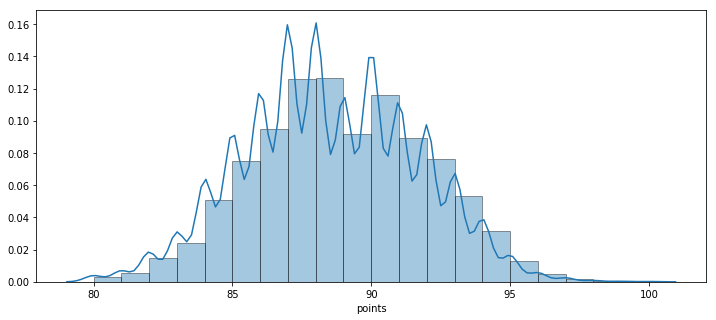

In [34]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

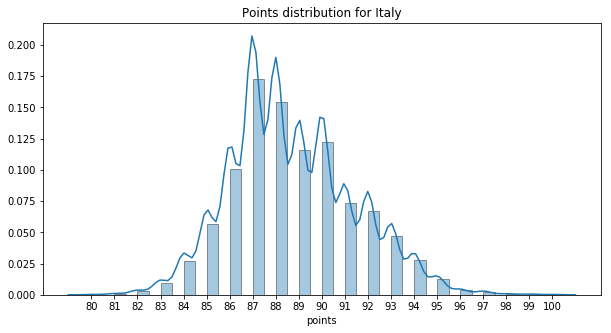

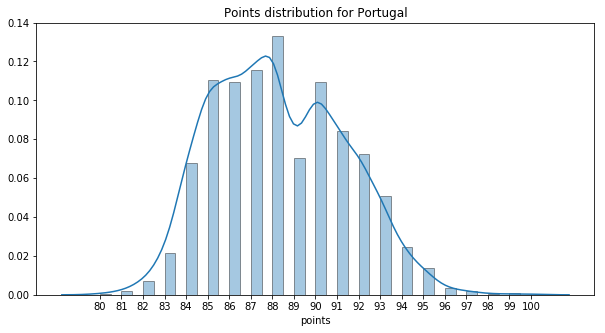

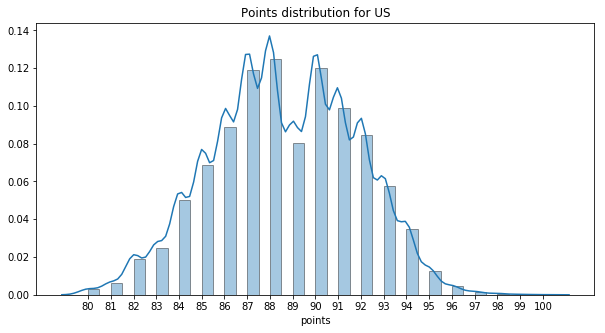

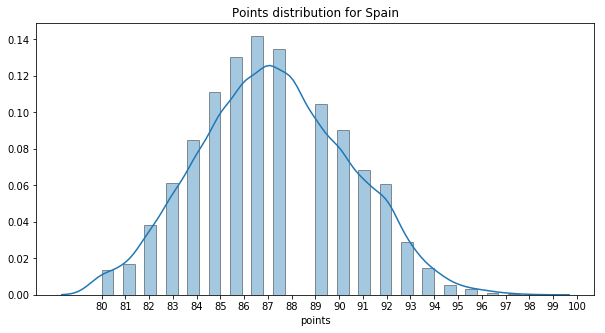

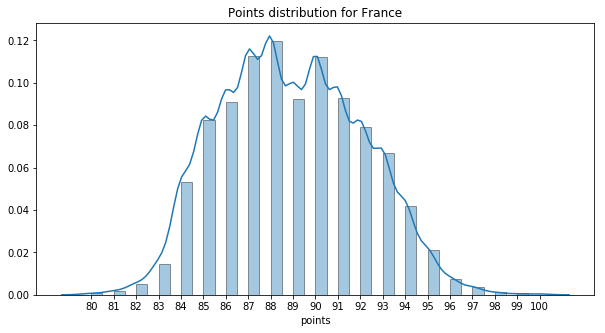

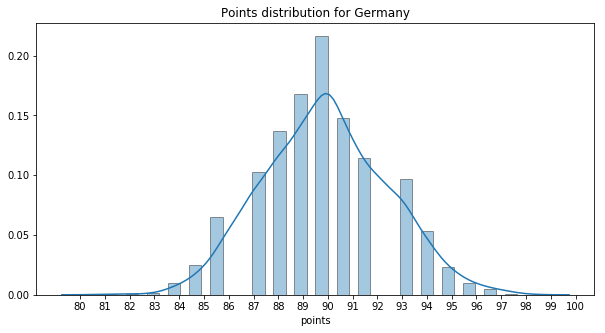

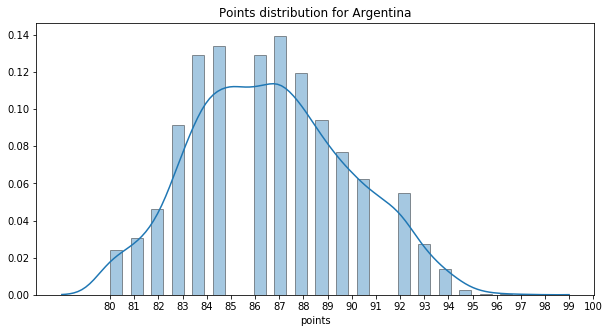

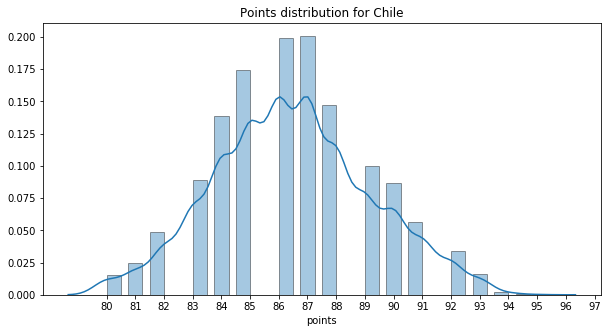

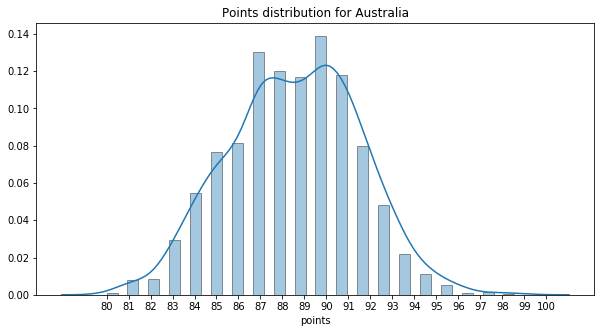

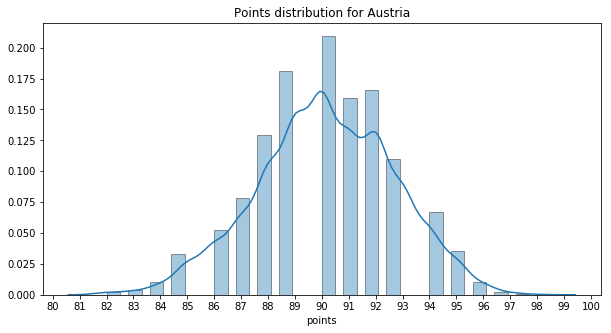

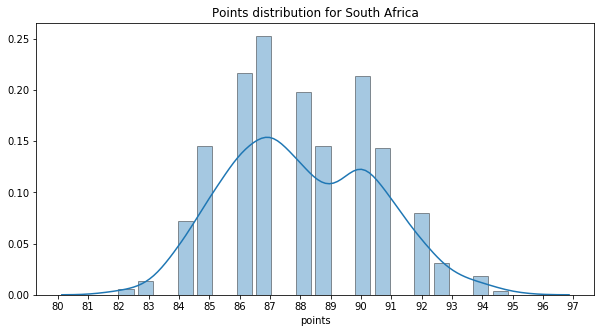

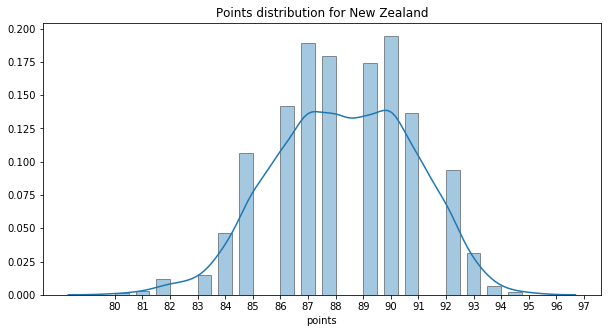

In [35]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Points distribution for " + c)
    ax.set(xticks=wine_base["points"].unique())
    sns.distplot(temp["points"],hist=True,bins = 20,hist_kws={"width": 0.5,'edgecolor':'black'})
    sns

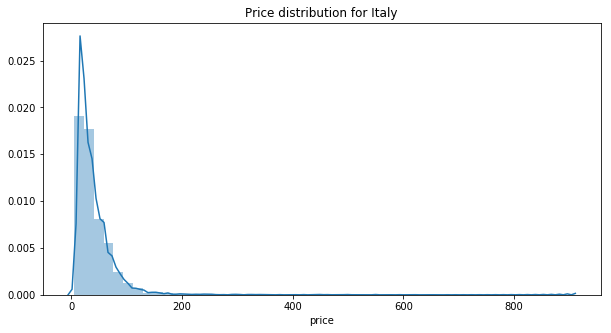

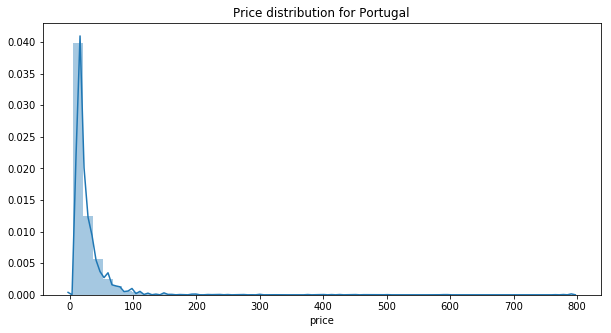

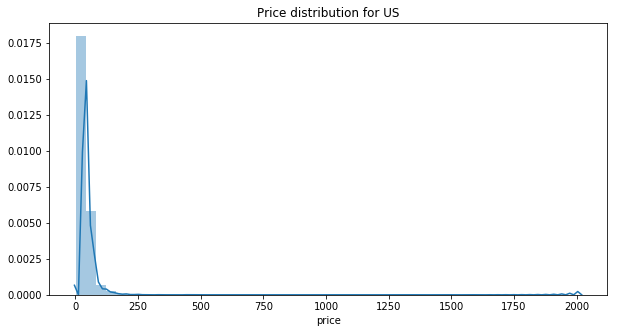

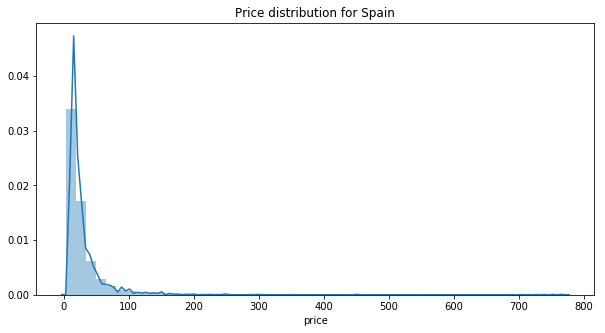

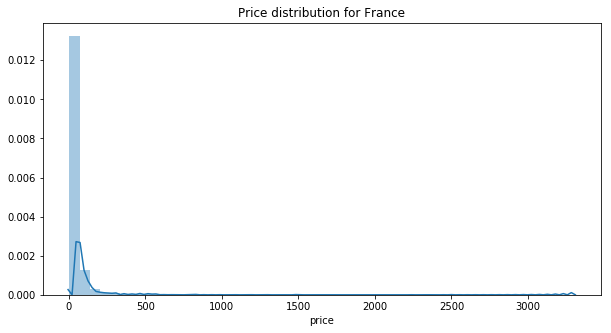

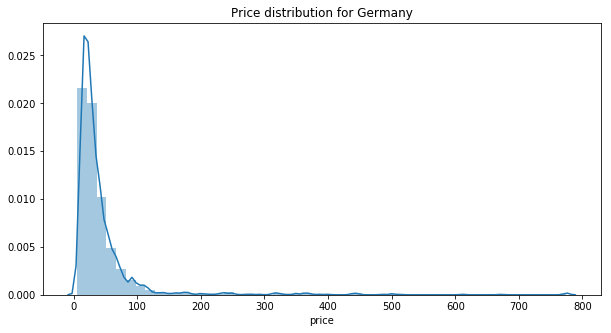

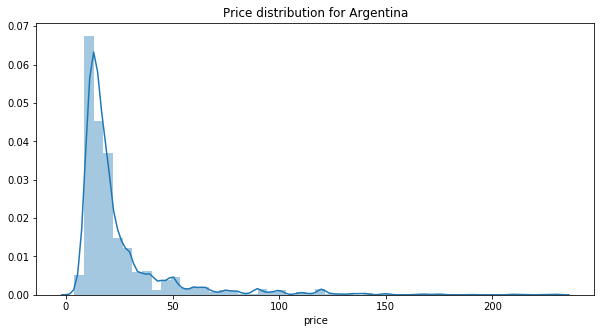

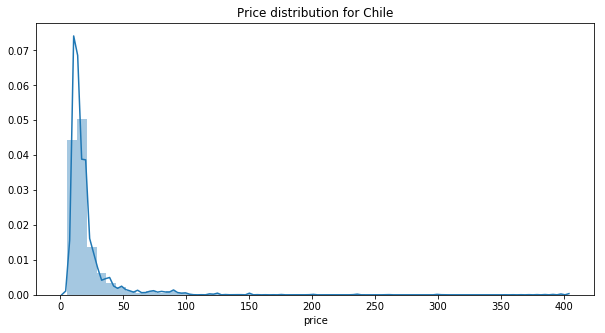

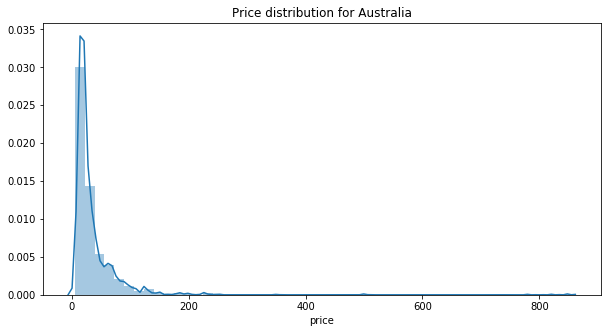

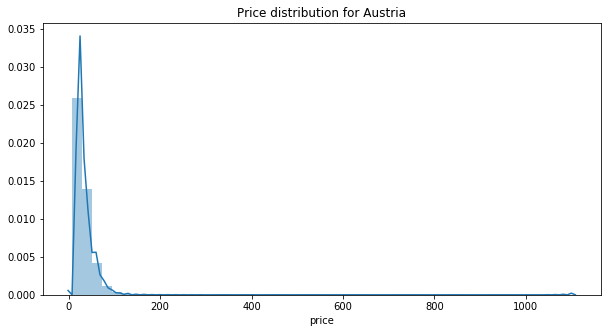

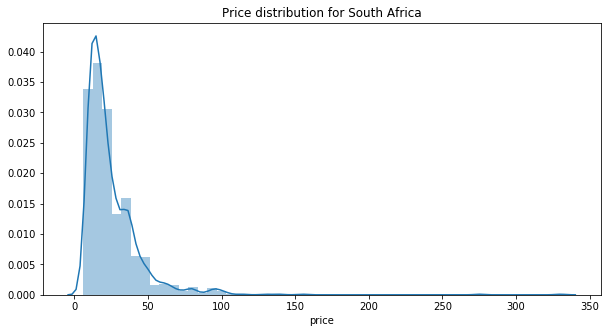

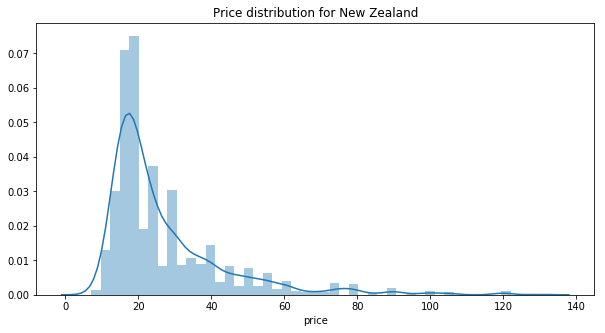

In [36]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Price distribution for " + c)
    sns.distplot(temp["price"],hist=True)
    sns

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

10.0


<module 'seaborn' from 'C:\\Users\\gneur\\Anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

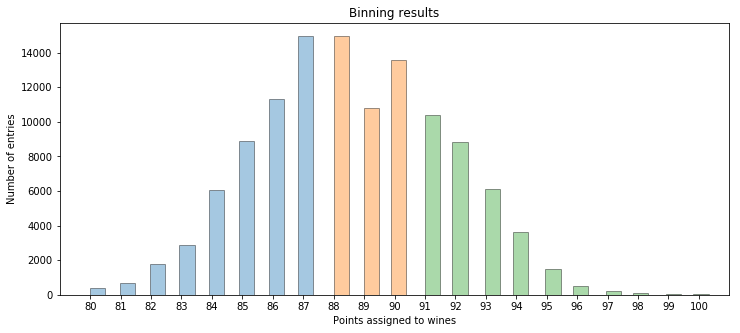

In [5]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
#tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
#tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
#tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
#tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + word2vec

# test stuff based on countries

In [37]:
countries = wine_base["country"].unique().tolist()
countries
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))
test = wine_base["country"].unique().tolist()
test

Italy 16965
Portugal 4950
US 49529
Spain 5637
France 18906
Germany 1978
Argentina 3495
Chile 4159
Australia 2130
Austria 2996
South Africa 1284
New Zealand 1268


['Italy',
 'Portugal',
 'US',
 'Spain',
 'France',
 'Germany',
 'Argentina',
 'Chile',
 'Australia',
 'Austria',
 'South Africa',
 'New Zealand']

In [38]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = pd.DataFrame()
        #obbiettivo è la categoria del dataframe X_train perchè è quello che contiene le righe giuste per le country
        y_train = list(X_train["category"])
        print(objCountry +" must not be in training set " + str(X_train["country"].unique().tolist()))
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [39]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
word2vec = ['similarityTop3WinesByVariety']
features = []
for el in wine_base.columns:
    if el != "description":
        features.append(el)

result = testByCountry(wine_base,countries)
len(result.columns.tolist())
result.drop("input",inplace=True,axis=1)
result

Italy must not be in training set ['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Portugal must not be in training set ['Italy', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
US must not be in training set ['Italy', 'Portugal', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Spain must not be in training set ['Italy', 'Portugal', 'US', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
France must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Germany must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'France', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Argentina must not be in training set ['

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Italy,0.540875,0.551253,0.534641,2,0.536900,0.653280,0.589400,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,decTree,Italy,0.558822,0.532449,0.518109,3,0.452237,0.879771,0.597392,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,decTree,Italy,0.559734,0.550074,0.548468,4,0.521223,0.701422,0.598043,4009,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.073605
3,decTree,Italy,0.577805,0.570292,0.566277,5,0.523411,0.764031,0.621235,4009,...,0.000000,0.0,0.0,0.007751,0.003321,0.004601,0.0,0.0,0.0,0.067392
4,decTree,Italy,0.569303,0.551960,0.546850,6,0.481746,0.789973,0.598507,4009,...,0.000000,0.0,0.0,0.010747,0.003122,0.004325,0.0,0.0,0.0,0.063353
0,decTree,Portugal,0.541997,0.508081,0.442017,2,0.849802,0.172138,0.286285,1249,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,decTree,Portugal,0.600678,0.589899,0.565494,3,0.791171,0.373098,0.507073,1249,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,decTree,Portugal,0.598279,0.579596,0.552366,4,0.797980,0.316253,0.452982,1249,...,0.000000,0.0,0.0,0.000000,0.003216,0.013931,0.0,0.0,0.0,0.044407
3,decTree,Portugal,0.598447,0.580404,0.552089,5,0.799189,0.315452,0.452354,1249,...,0.000000,0.0,0.0,0.000000,0.002960,0.012821,0.0,0.0,0.0,0.051980
4,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.011675,0.0,0.0,0.005781,0.002797,0.012115,0.0,0.0,0.0,0.049117


In [40]:
#if the column is never used delete it
for col in result.columns:
    if len(result[col].unique().tolist()) == 1 and col != "algorithm":
        result.drop(col,inplace=True,axis=1)
result.columns

Index(['algorithm', 'ObjectiveCountry', 'precision', 'accuracy', 'f1', 'depth',
       'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec',
       'medium_recall', 'medium_f1', 'medium_support', 'high_prec',
       'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety',
       'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage',
       'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima',
       'feat_Anne Krebiehl MW', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe',
       'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss',
       'feat_unknown'],
      dtype='object')

In [41]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
result = result.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = result.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_vintage,feat_Alexander Peartree,feat_Anna Lee C. Iijima,feat_Anne Krebiehl MW,feat_Joe Czerwinski,feat_Kerin O’Keefe,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_unknown
0,decTree,US,0.578296,0.554483,0.560891,6,0.582740,0.598347,0.590440,14637,...,0.000333,0.000000,0.003330,0.047619,0.002773,0.027777,0.005250,0.000000,0.000000,0.006340
5,decTree,Spain,0.690139,0.651943,0.663278,4,0.608974,0.616216,0.612574,925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019550,0.065441
10,decTree,South Africa,0.688041,0.678349,0.681595,4,0.610487,0.705628,0.654618,231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018750,0.060174
15,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.002343,0.000000,0.002381,0.020696,0.000000,0.011675,0.005781,0.002797,0.012115,0.049117
20,decTree,New Zealand,0.553157,0.552050,0.552515,3,0.556818,0.571984,0.564299,257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,decTree,Italy,0.577805,0.570292,0.566277,5,0.523411,0.764031,0.621235,4009,...,0.000000,0.000000,0.000000,0.010185,0.000000,0.000000,0.007751,0.003321,0.004601,0.067392
30,decTree,Germany,0.603794,0.571790,0.577144,6,0.750936,0.529024,0.620743,758,...,0.006964,0.000000,0.000119,0.018147,0.000000,0.009219,0.003357,0.002692,0.014585,0.048661
35,decTree,France,0.618510,0.578917,0.587323,5,0.727654,0.610981,0.664233,5956,...,0.013589,0.000000,0.000000,0.008734,0.000000,0.011772,0.000000,0.003640,0.000000,0.046503
40,decTree,Chile,0.757597,0.720846,0.733832,4,0.531486,0.622419,0.573370,339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018080,0.065196
45,decTree,Austria,0.587857,0.533044,0.545578,6,0.768332,0.548558,0.640106,1318,...,0.007570,0.000097,0.001810,0.001173,0.000000,0.009094,0.003590,0.003030,0.016231,0.050737


# Analyse general country stuff

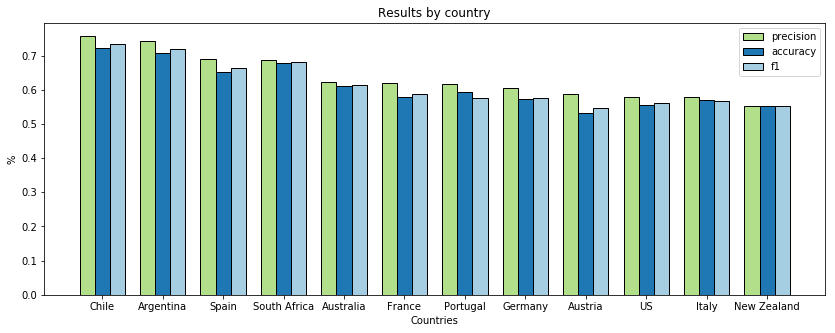

In [42]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


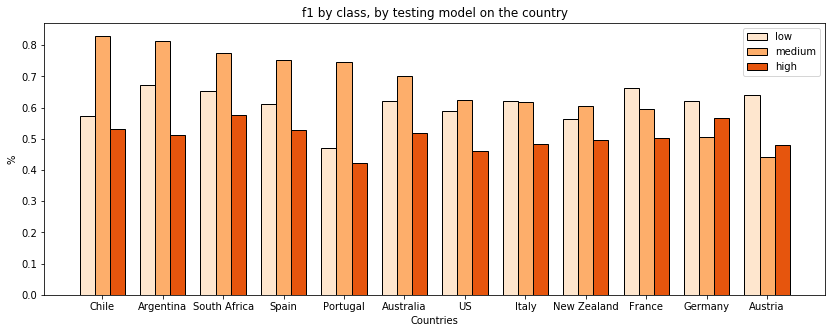

In [45]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_f1","medium_f1","high_f1"]]
temp = temp.sort_values(["medium_f1","high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("f1 by class, by testing model on the country") 
# Show graphic
plt.show()

# Per country, visualize  what influences the decision tree 
IT DOESN'T TAKE INTO ACCOUNT PRICE BECAUSE IT WOULD MAKE EVERY KIND OF VISUALIZATION USELESS

In [46]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = result.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

['feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']


,ObjectiveCountry,feat_price,feat_variety,feat_similarityTop3WinesByVariety,feat_word_count,feat_vintage,feat_Alexander Peartree,feat_Anna Lee C. Iijima,feat_Anne Krebiehl MW,feat_Joe Czerwinski,feat_Kerin O’Keefe,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_unknown
0,Argentina,0.790081,0.000000,0.016103,0.137005,0.000986,0.000020,0.000354,0.004546,0.000000,0.003035,0.000000,0.001213,0.010767,0.035890
1,Australia,0.796725,0.000043,0.015436,0.132167,0.002536,0.000019,0.000354,0.004331,0.000000,0.002369,0.000674,0.001224,0.010357,0.033765
2,Austria,0.803250,0.000000,0.017003,0.135658,0.001514,0.000019,0.000362,0.000235,0.000000,0.001819,0.001189,0.001249,0.009462,0.028240
3,Chile,0.785394,0.000045,0.014719,0.143046,0.002197,0.000115,0.000000,0.004069,0.000000,0.002493,0.000000,0.000455,0.010531,0.036936
4,France,0.708536,0.000119,0.027428,0.212966,0.005681,0.000000,0.000410,0.003956,0.000000,0.005365,0.000752,0.001413,0.000000,0.033374
5,Germany,0.799146,0.000043,0.013914,0.136381,0.001393,0.000000,0.000024,0.006822,0.000000,0.001844,0.000671,0.001729,0.009368,0.028666
6,Italy,0.788368,0.000266,0.024081,0.131452,0.002784,0.000123,0.000370,0.004913,0.000000,0.000000,0.003700,0.001289,0.001785,0.040870
7,New Zealand,0.797105,0.000042,0.015697,0.131897,0.001899,0.000019,0.000347,0.002517,0.000000,0.002176,0.001774,0.001205,0.010094,0.035227
8,Portugal,0.757460,0.000010,0.012653,0.178253,0.000469,0.000000,0.000476,0.008520,0.000000,0.002335,0.001156,0.001794,0.007773,0.029101
9,South Africa,0.795529,0.000043,0.016193,0.131512,0.001986,0.000000,0.000348,0.002509,0.000000,0.003359,0.001882,0.001208,0.010896,0.034536


['feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.09908847969661516, 0.5408560930590063, 0.15308566523231812, 0.16149874974050937, 0.25776758698696395, 0.14843190032564374, 0.24431734005897457, 0.6761054667007376, 0.9498214871306302, 0.8698102245290121]


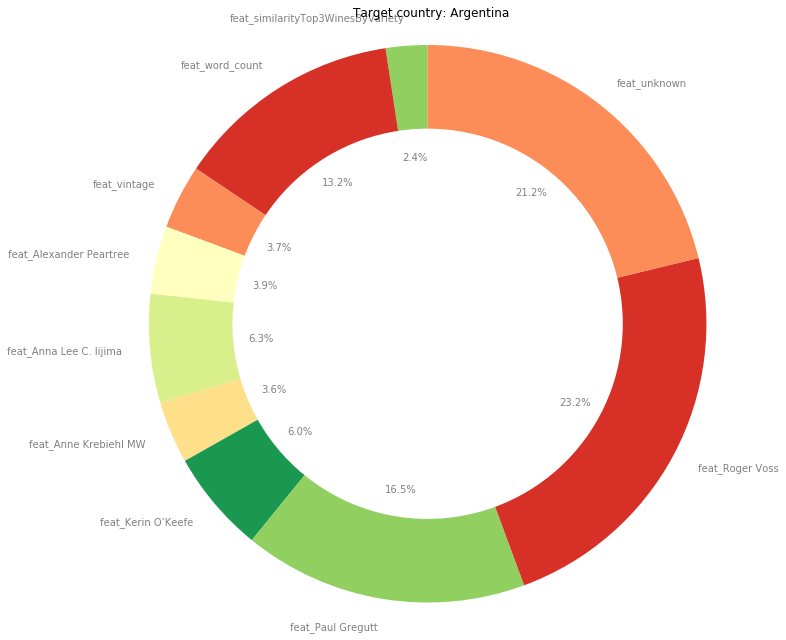

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.16206411682278712, 0.07993023254531784, 0.511611295822832, 0.4326192603557574, 0.1576493445489356, 0.25711791957259145, 0.14105397675784212, 0.1906794471200179, 0.18230366745762772, 0.6821739612552357, 0.9136514974858679, 0.8142718612356441]


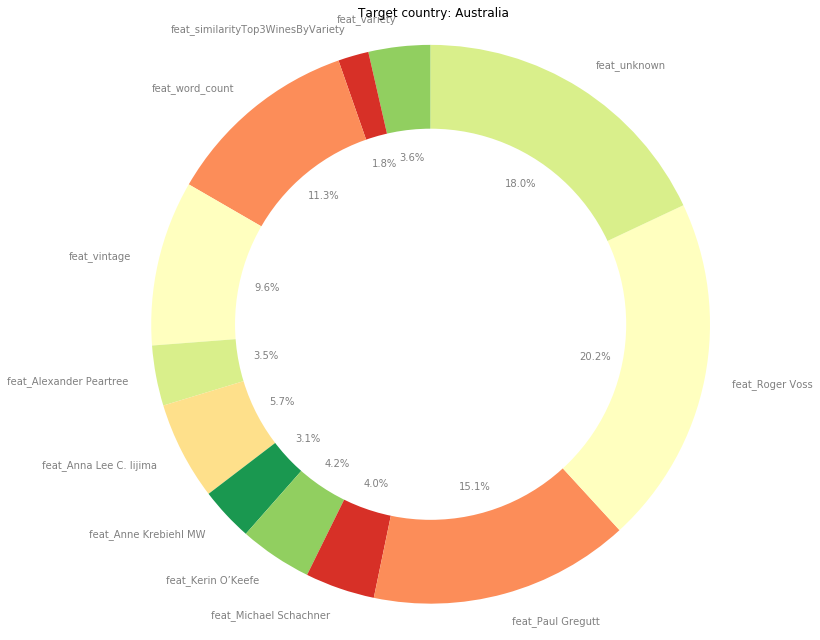

['feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.12495766854879453, 0.5327136682924705, 0.248338812223472, 0.157524136939001, 0.2633506019549553, 0.1464114325000781, 0.3213220195628955, 0.6960590957344513, 0.8346627859806425, 0.669835608848573]


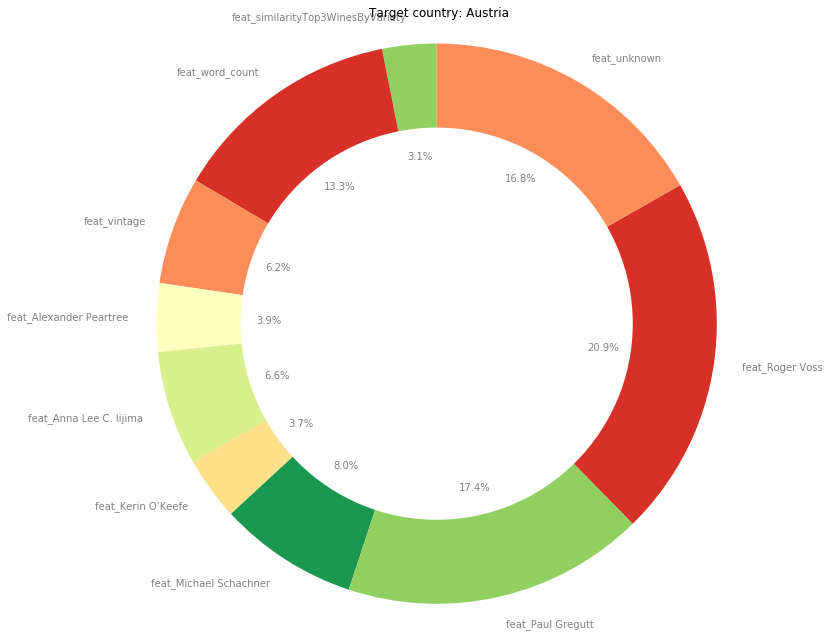

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.1679492050523324, 0.05932433734867937, 0.577372377107868, 0.3715447842215025, 0.9316681194902818, 0.1320180971450288, 0.20069916614916655, 0.2533906336008503, 0.9290413236319842, 0.8971567119545496]


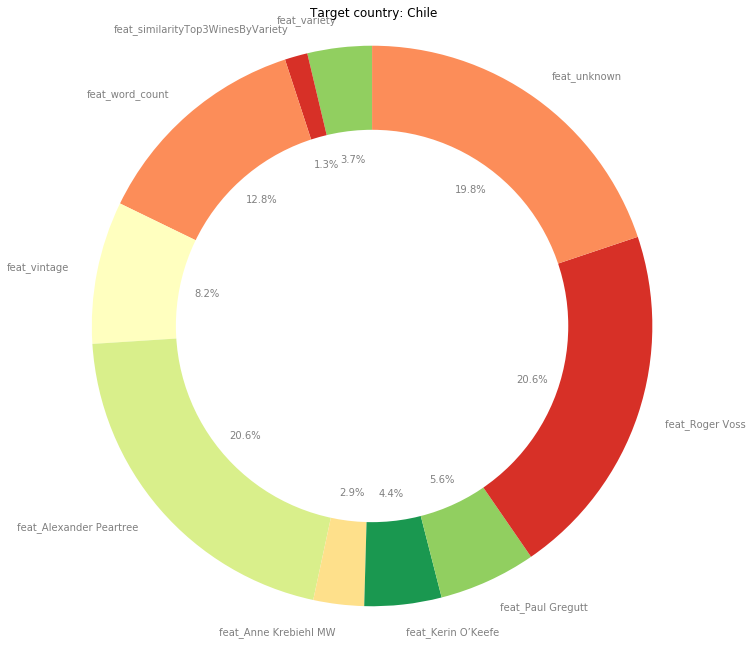

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_unknown']
[0.44644952477943184, 0.42439688723281227, 0.9999999999999998, 1.0000000000000002, 0.2979603427951981, 0.12812305290871007, 0.4318661756181, 0.20339393673664502, 0.7875047940217786, 0.8040266425060802]


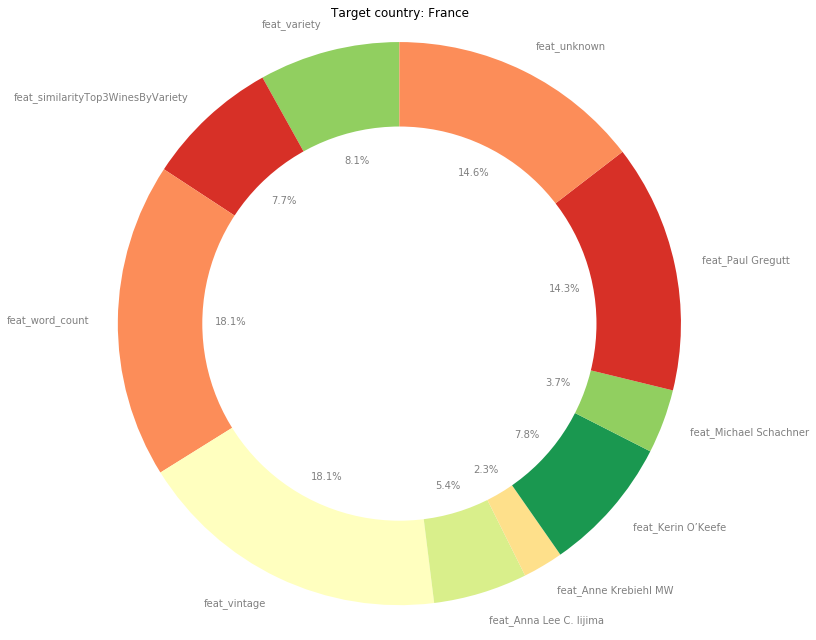

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.16180792031715643, 0.036202582963006213, 0.5370881859649974, 0.22647777143458755, 0.01724646649482096, 0.2267961318526746, 0.1484176528257512, 0.18146846117417914, 0.9634191951273816, 0.8263905725633174, 0.6809699948540823]


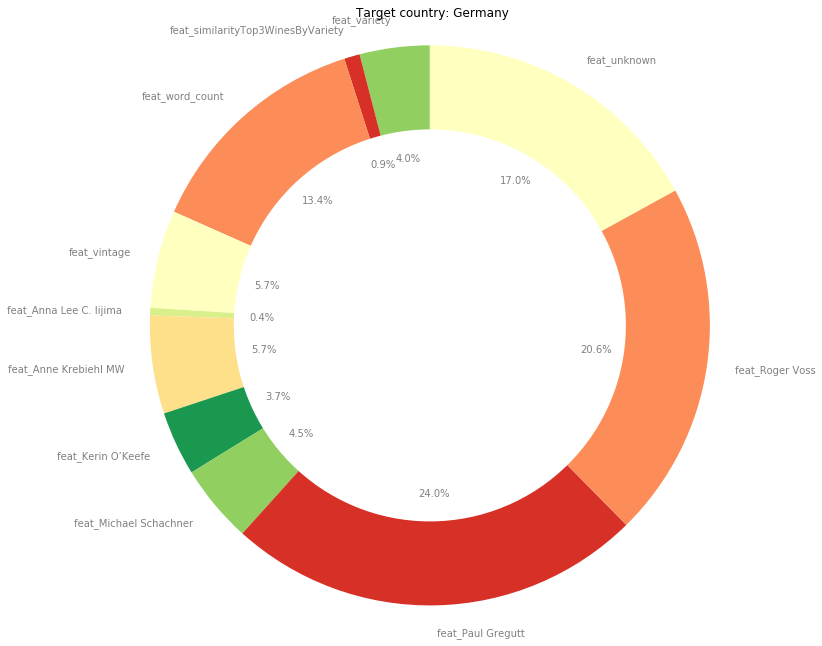

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[1.0, 0.32825661490627517, 0.5072924001429462, 0.4773700082946258, 1.0, 0.2692563817662347, 0.16106107780122692, 1.0, 0.7181925911084024, 0.15748203646348802, 0.9999999999999999]


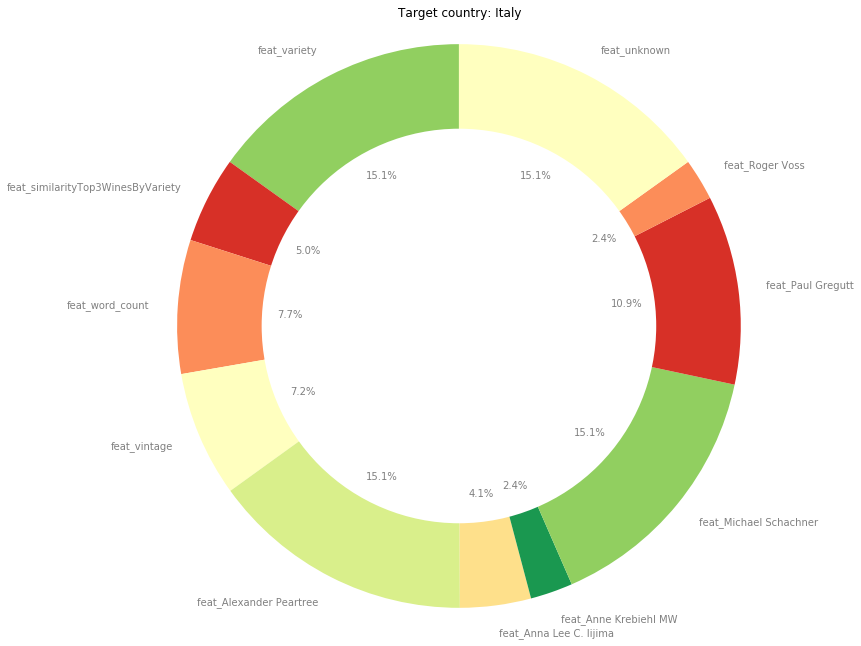

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.1596155336086765, 0.0874219322837737, 0.5099830762279787, 0.31768803787681693, 0.15515138601165207, 0.2526835997557932, 0.0785945505804123, 0.1751785956093591, 0.4796468495018584, 0.6715896382698728, 0.8904736611986346, 0.8524695889862519]


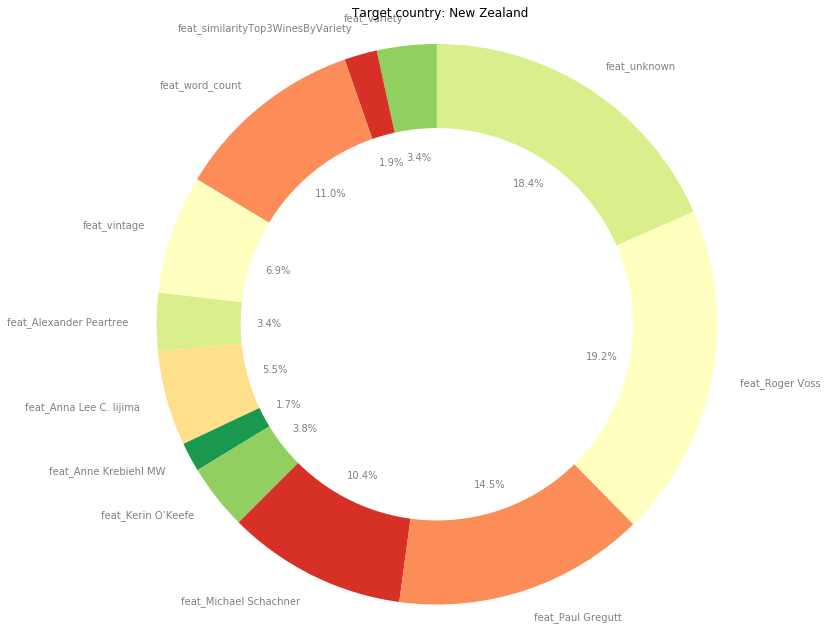

['feat_variety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.036340321919669634, 0.7901779198637939, 0.059751512901803694, 0.34637160088179997, 0.2852505682654487, 0.18795877281441675, 0.31250695413206764, 1.0, 0.6857363942763831, 0.6923312158732087]


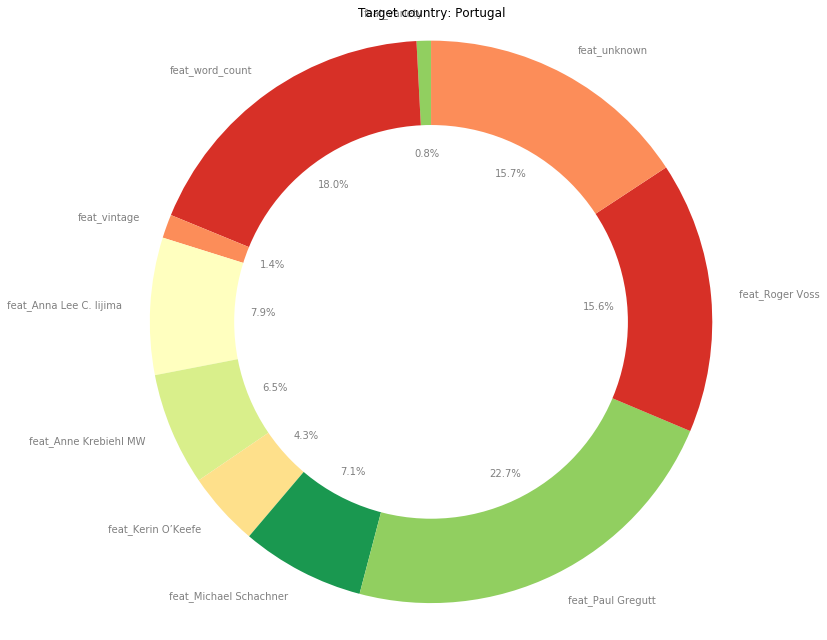

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.1606685197250723, 0.1016900427962979, 0.507657378782284, 0.33339430123089636, 0.25342715986404135, 0.07830281805385086, 0.27037556438551813, 0.5087324417071056, 0.6729793748021934, 0.9611775877398326, 0.8344100207549728]


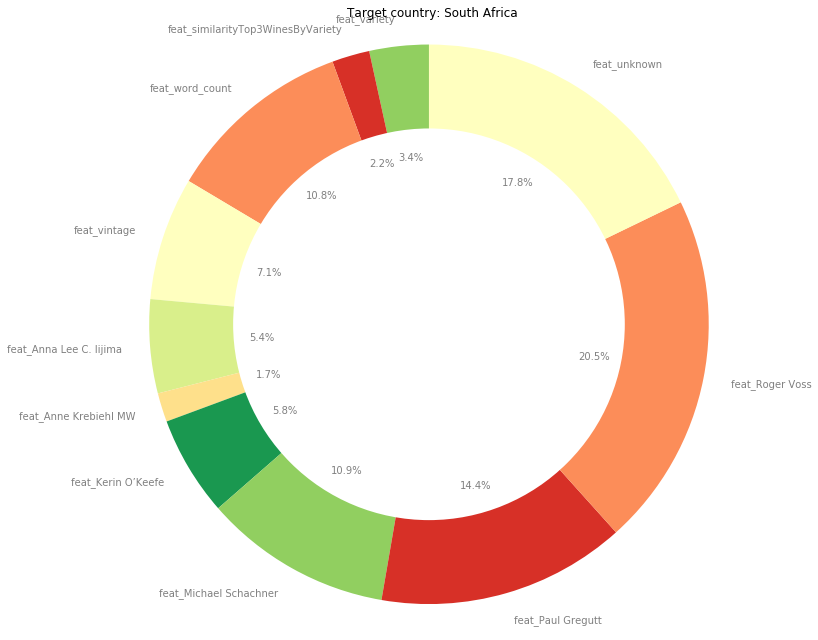

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown']
[0.16742394734518065, 0.13951538001129143, 0.5426844223392056, 0.2719680741401461, 0.16287104282135098, 0.4218728354081361, 0.09187769653553393, 0.28932548275932224, 0.5220487116175341, 0.4533326026896971, 1.0, 0.9178820920443097]


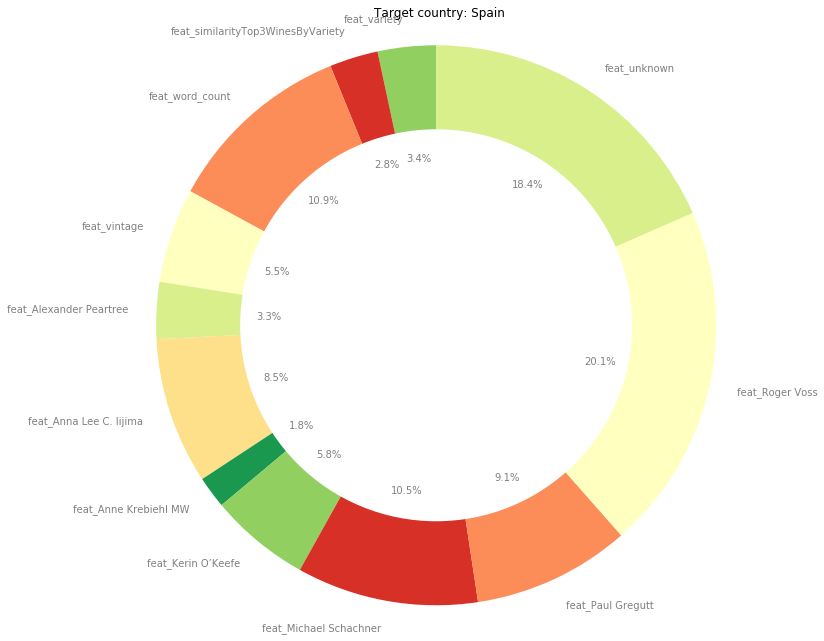

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Michael Schachner']
[0.44504313634706966, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.28380178089614105]


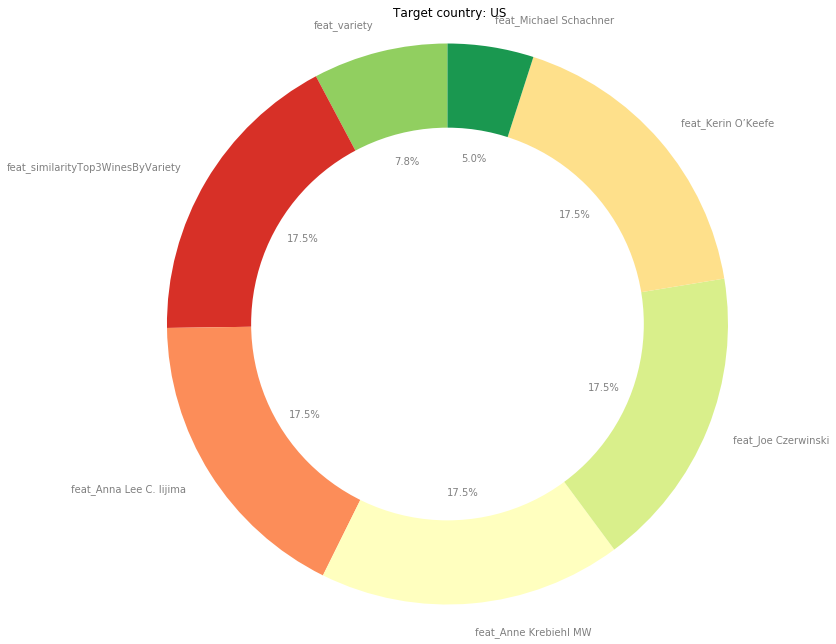

In [47]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

[['feat_similarityTop3WinesByVariety', 0.09908847969661516], ['feat_Anne Krebiehl\xa0MW', 0.14843190032564374], ['feat_vintage', 0.15308566523231812], ['feat_Alexander Peartree', 0.16149874974050937], ['feat_Kerin O’Keefe', 0.24431734005897457], ['feat_Anna Lee C. Iijima', 0.25776758698696395], ['feat_word_count', 0.5408560930590063], ['feat_Paul Gregutt', 0.6761054667007376], ['feat_unknown', 0.8698102245290121], ['feat_Roger Voss', 0.9498214871306302]]


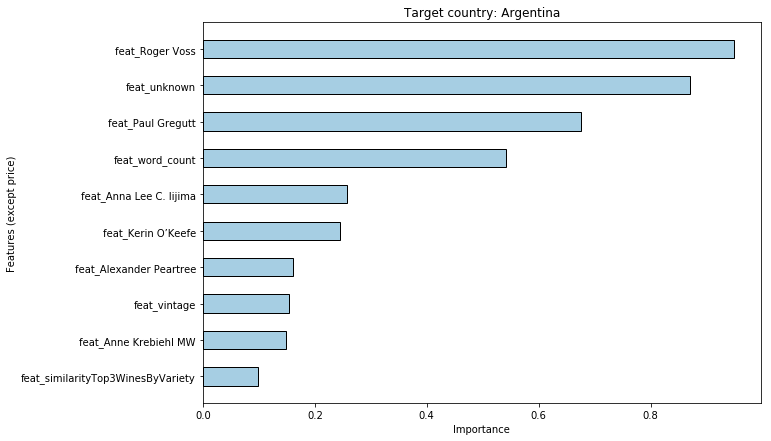

[['feat_similarityTop3WinesByVariety', 0.07993023254531784], ['feat_Anne Krebiehl\xa0MW', 0.14105397675784212], ['feat_Alexander Peartree', 0.1576493445489356], ['feat_variety', 0.16206411682278712], ['feat_Michael Schachner', 0.18230366745762772], ['feat_Kerin O’Keefe', 0.1906794471200179], ['feat_Anna Lee C. Iijima', 0.25711791957259145], ['feat_vintage', 0.4326192603557574], ['feat_word_count', 0.511611295822832], ['feat_Paul Gregutt', 0.6821739612552357], ['feat_unknown', 0.8142718612356441], ['feat_Roger Voss', 0.9136514974858679]]


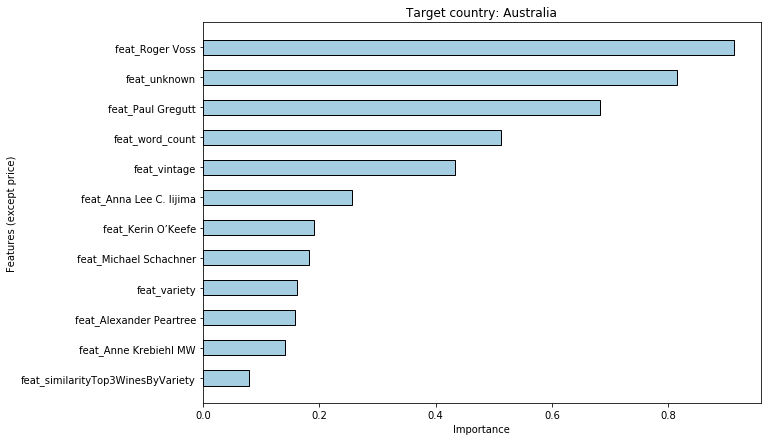

[['feat_similarityTop3WinesByVariety', 0.12495766854879453], ['feat_Kerin O’Keefe', 0.1464114325000781], ['feat_Alexander Peartree', 0.157524136939001], ['feat_vintage', 0.248338812223472], ['feat_Anna Lee C. Iijima', 0.2633506019549553], ['feat_Michael Schachner', 0.3213220195628955], ['feat_word_count', 0.5327136682924705], ['feat_unknown', 0.669835608848573], ['feat_Paul Gregutt', 0.6960590957344513], ['feat_Roger Voss', 0.8346627859806425]]


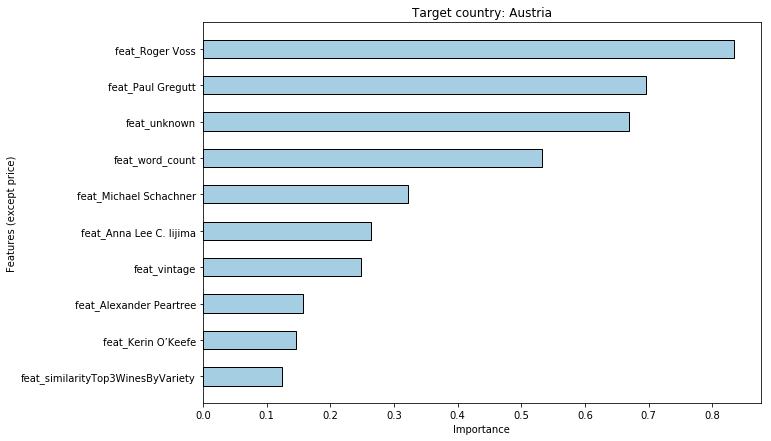

[['feat_similarityTop3WinesByVariety', 0.05932433734867937], ['feat_Anne Krebiehl\xa0MW', 0.1320180971450288], ['feat_variety', 0.1679492050523324], ['feat_Kerin O’Keefe', 0.20069916614916655], ['feat_Paul Gregutt', 0.2533906336008503], ['feat_vintage', 0.3715447842215025], ['feat_word_count', 0.577372377107868], ['feat_unknown', 0.8971567119545496], ['feat_Roger Voss', 0.9290413236319842], ['feat_Alexander Peartree', 0.9316681194902818]]


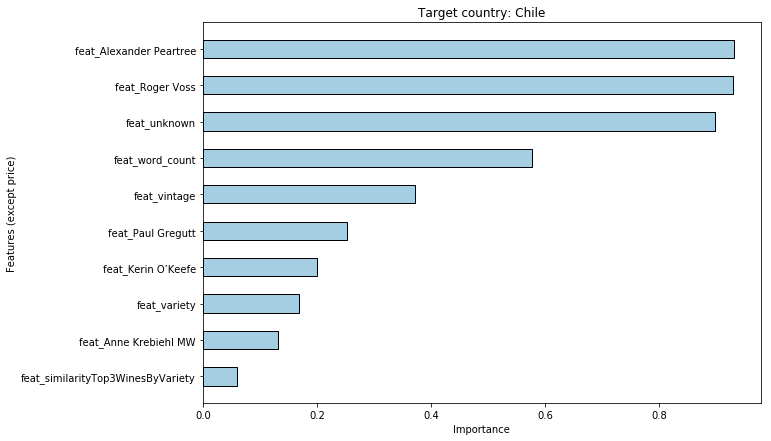

[['feat_Anne Krebiehl\xa0MW', 0.12812305290871007], ['feat_Michael Schachner', 0.20339393673664502], ['feat_Anna Lee C. Iijima', 0.2979603427951981], ['feat_similarityTop3WinesByVariety', 0.42439688723281227], ['feat_Kerin O’Keefe', 0.4318661756181], ['feat_variety', 0.44644952477943184], ['feat_Paul Gregutt', 0.7875047940217786], ['feat_unknown', 0.8040266425060802], ['feat_word_count', 0.9999999999999998], ['feat_vintage', 1.0000000000000002]]


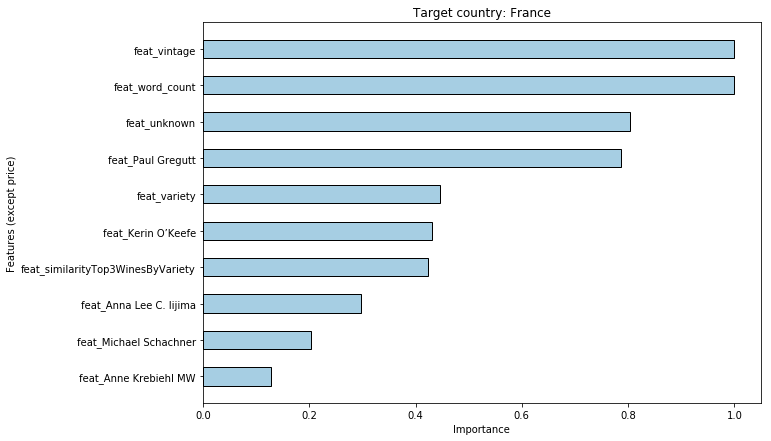

[['feat_Anna Lee C. Iijima', 0.01724646649482096], ['feat_similarityTop3WinesByVariety', 0.036202582963006213], ['feat_Kerin O’Keefe', 0.1484176528257512], ['feat_variety', 0.16180792031715643], ['feat_Michael Schachner', 0.18146846117417914], ['feat_vintage', 0.22647777143458755], ['feat_Anne Krebiehl\xa0MW', 0.2267961318526746], ['feat_word_count', 0.5370881859649974], ['feat_unknown', 0.6809699948540823], ['feat_Roger Voss', 0.8263905725633174], ['feat_Paul Gregutt', 0.9634191951273816]]


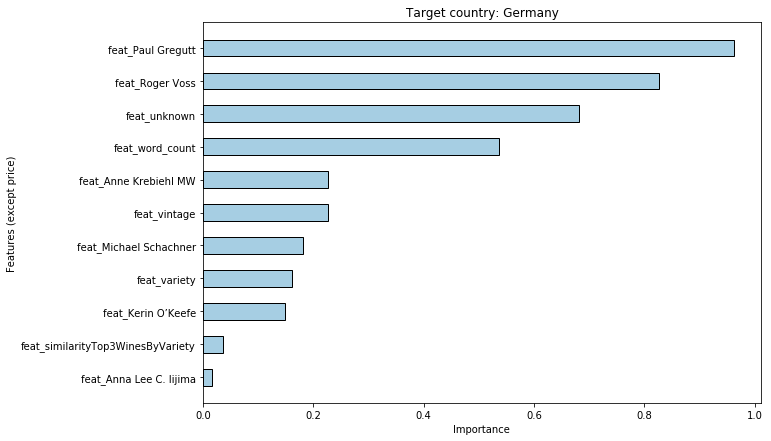

[['feat_Roger Voss', 0.15748203646348802], ['feat_Anne Krebiehl\xa0MW', 0.16106107780122692], ['feat_Anna Lee C. Iijima', 0.2692563817662347], ['feat_similarityTop3WinesByVariety', 0.32825661490627517], ['feat_vintage', 0.4773700082946258], ['feat_word_count', 0.5072924001429462], ['feat_Paul Gregutt', 0.7181925911084024], ['feat_unknown', 0.9999999999999999], ['feat_variety', 1.0], ['feat_Alexander Peartree', 1.0], ['feat_Michael Schachner', 1.0]]


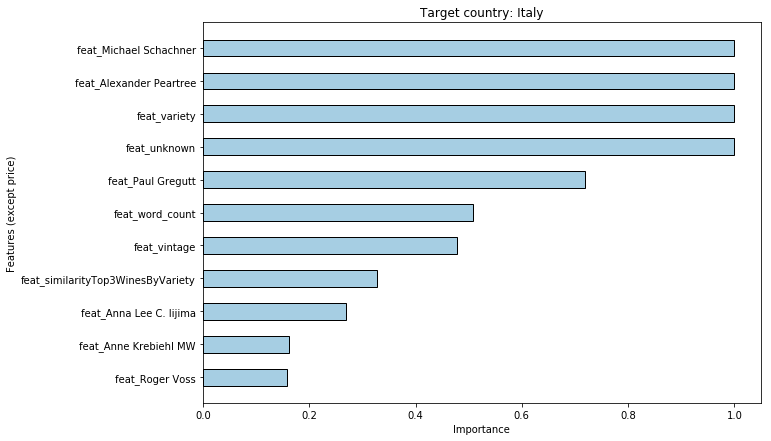

[['feat_Anne Krebiehl\xa0MW', 0.0785945505804123], ['feat_similarityTop3WinesByVariety', 0.0874219322837737], ['feat_Alexander Peartree', 0.15515138601165207], ['feat_variety', 0.1596155336086765], ['feat_Kerin O’Keefe', 0.1751785956093591], ['feat_Anna Lee C. Iijima', 0.2526835997557932], ['feat_vintage', 0.31768803787681693], ['feat_Michael Schachner', 0.4796468495018584], ['feat_word_count', 0.5099830762279787], ['feat_Paul Gregutt', 0.6715896382698728], ['feat_unknown', 0.8524695889862519], ['feat_Roger Voss', 0.8904736611986346]]


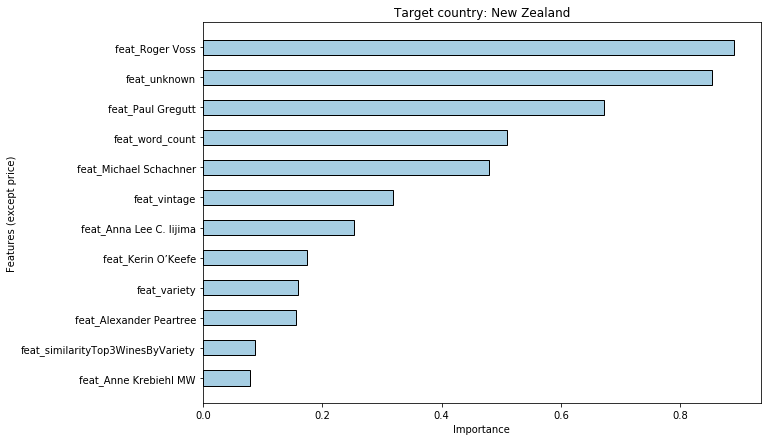

[['feat_variety', 0.036340321919669634], ['feat_vintage', 0.059751512901803694], ['feat_Kerin O’Keefe', 0.18795877281441675], ['feat_Anne Krebiehl\xa0MW', 0.2852505682654487], ['feat_Michael Schachner', 0.31250695413206764], ['feat_Anna Lee C. Iijima', 0.34637160088179997], ['feat_Roger Voss', 0.6857363942763831], ['feat_unknown', 0.6923312158732087], ['feat_word_count', 0.7901779198637939], ['feat_Paul Gregutt', 1.0]]


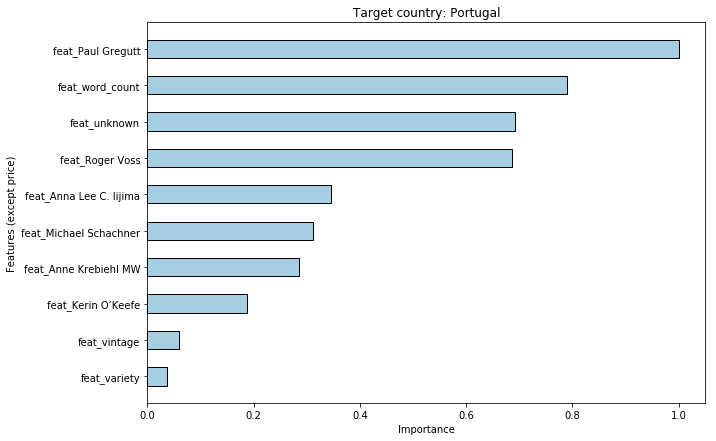

[['feat_Anne Krebiehl\xa0MW', 0.07830281805385086], ['feat_similarityTop3WinesByVariety', 0.1016900427962979], ['feat_variety', 0.1606685197250723], ['feat_Anna Lee C. Iijima', 0.25342715986404135], ['feat_Kerin O’Keefe', 0.27037556438551813], ['feat_vintage', 0.33339430123089636], ['feat_word_count', 0.507657378782284], ['feat_Michael Schachner', 0.5087324417071056], ['feat_Paul Gregutt', 0.6729793748021934], ['feat_unknown', 0.8344100207549728], ['feat_Roger Voss', 0.9611775877398326]]


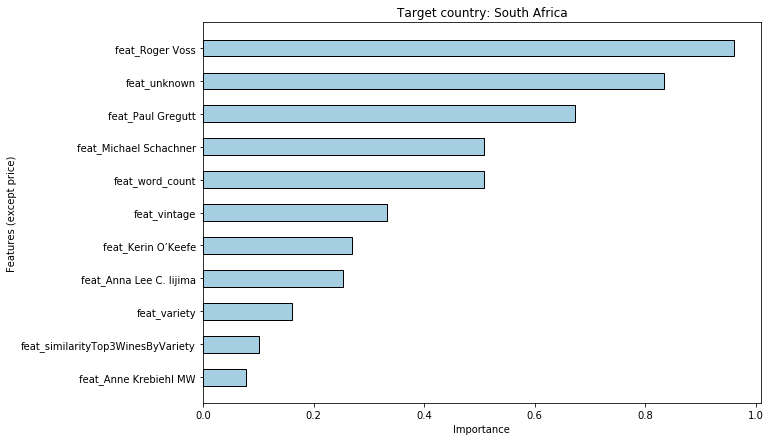

[['feat_Anne Krebiehl\xa0MW', 0.09187769653553393], ['feat_similarityTop3WinesByVariety', 0.13951538001129143], ['feat_Alexander Peartree', 0.16287104282135098], ['feat_variety', 0.16742394734518065], ['feat_vintage', 0.2719680741401461], ['feat_Kerin O’Keefe', 0.28932548275932224], ['feat_Anna Lee C. Iijima', 0.4218728354081361], ['feat_Paul Gregutt', 0.4533326026896971], ['feat_Michael Schachner', 0.5220487116175341], ['feat_word_count', 0.5426844223392056], ['feat_unknown', 0.9178820920443097], ['feat_Roger Voss', 1.0]]


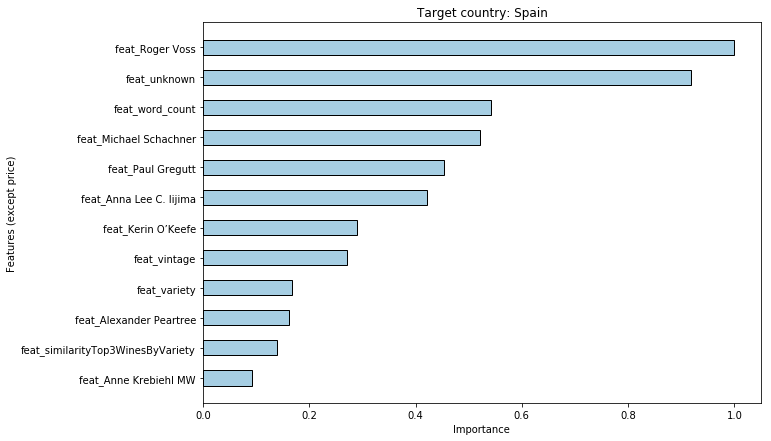

[['feat_Michael Schachner', 0.28380178089614105], ['feat_variety', 0.44504313634706966], ['feat_Anne Krebiehl\xa0MW', 0.9999999999999999], ['feat_similarityTop3WinesByVariety', 1.0], ['feat_Anna Lee C. Iijima', 1.0], ['feat_Joe Czerwinski', 1.0], ['feat_Kerin O’Keefe', 1.0]]


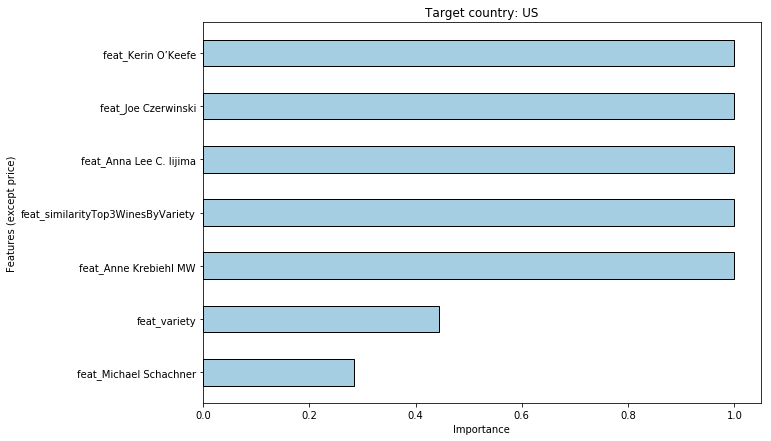

In [48]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# radar chart to compare importances between regression and dectrees?

In [ ]:
#"algorithm" feaeture must be in the dataset here

df1 = result.head(4)
test = result.iloc[5]
feats = []
values = []

genFeatures = []
for col in result.columns:
    if(col.startswith("feat_")):
            genFeatures.append(col)
print(genFeatures)

for col in result.columns:
    if(col.startswith("feat_")) and (test[col] != 100):
        print(col,test[col])
        feats.append(col)
        values.append(test[col])
df1

In [ ]:
#per il radar chart, va bene probabilmente solo per la comparazione dei risultati delle importanze per linear regression e dectreeclass

#oppure anche per i risultati di precision recall e f1 score?

df = pd.DataFrame()
df = df1[["algorithm"] + genFeatures]
df = df.reset_index(drop=True)
#df.drop(["algorithm"],axis=1,inplace=True)
for col in df.columns:
    df[col] = df[col].replace(100,0)
    if len(df[col].unique().tolist()) == 1 and col != "algorithm":
        df.drop(col,inplace=True,axis=1)
df

In [ ]:
#devi costruire il dataframe 

In [ ]:
def make_spider(row, title):#,# color):
 
    # number of variable
    categories=list(df)[1:]
    #print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,idx+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","50","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[idx].drop("algorithm").values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.4)

    # Add a title
    plt.title(title, size=11, y=1.1)
    
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for idx,row in df.iterrows():
    make_spider(row,"culo") #,my_palette(row))

In [ ]:
df = df[df["feat_winery"] != 0]
df = df.reset_index(drop=True)
print(df)
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('algorithm').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","0.50","1"], color="grey", size=7)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)



# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data,Y):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    y_train = list(y_train)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print(acc,weightedPrec)
    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
temp = pd.DataFrame()
temp = wine_base
Y = temp['points'].copy()
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
temp = temp.drop(["points","country"],axis=1)
temp

In [ ]:
features = temp.columns
depth = 4
clf = decTree(features,depth,temp,Y)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [ ]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            counter = 0
            for name,importance in c:
                if importance > 0:
                    temp[name] = importance
                    counter += 1
            data.append(counter)
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]

# Classifier using sparse matrix, don't know why gives errors of type

wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]


for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset

wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)


wine_base.drop(["designation"],axis=1,inplace=True)


lb = LabelBinarizer()

wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes


def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    #compute countvectorizer
    
    vect = CountVectorizer(min_df=5)
    t = vect.fit_transform(X_train["description"])
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

#doesn't work dunno why
#change the input and compute

depth = 3
test_size = 0.30
tem = pd.DataFrame()
tem = wine_base.drop("points",axis=1)
features = ["price","description"]
clf = sparseMatrixRep(features,depth,tem,test_size)

#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# TRAIN ON ONE COUNTRY, TEST ON THE OTHERS

In [ ]:
#wine_base["country_tag"] = wine_base["country"].astype('category').cat.codes
#wine_base.drop("region_1",inplace=True,axis=1)

#this way, the only missing attribute is the country, so that the classifier doesn't work on which country it comes from

In [49]:
def trainByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest1(wine3,el)
        df = df.append(res)
    return df

def applyTest1(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    print("ARGS " + str(args))
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult1(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult1(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    print(cols)
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] != objCountry]
        y_test = X_test["category"]
        print(str(X_test["country"].unique().tolist()) + "country in the test set")
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [50]:
trainedOnSingleCountry = trainByCountry(wine_base,countries)
trainedOnSingleCountry.drop("input",inplace=True,axis=1)
trainedOnSingleCountry

ARGS ['price', 'variety', 'similarityTop3WinesByVariety', 'word_count', 'vintage', 'Alexander Peartree', 'Anna Lee C. Iijima', 'Anne Krebiehl\xa0MW', 'Carrie Dykes', 'Christina Pickard', 'Fiona Adams', 'Jim Gordon', 'Joe Czerwinski', 'Kerin O’Keefe', 'Lauren Buzzeo', 'Matt Kettmann', 'Michael Schachner', 'Paul Gregutt', 'Roger Voss', 'Sean P. Sullivan', 'Susan Kostrzewa', 'Virginie Boone', 'unknown']
['algorithm', 'ObjectiveCountry', 'input', 'precision', 'accuracy', 'f1', 'depth', 'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec', 'medium_recall', 'medium_f1', 'medium_support', 'high_prec', 'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Christina Pickard', 'feat_Fiona Adams', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_M

ARGS ['price', 'variety', 'similarityTop3WinesByVariety', 'word_count', 'vintage', 'Alexander Peartree', 'Anna Lee C. Iijima', 'Anne Krebiehl\xa0MW', 'Carrie Dykes', 'Christina Pickard', 'Fiona Adams', 'Jim Gordon', 'Joe Czerwinski', 'Kerin O’Keefe', 'Lauren Buzzeo', 'Matt Kettmann', 'Michael Schachner', 'Paul Gregutt', 'Roger Voss', 'Sean P. Sullivan', 'Susan Kostrzewa', 'Virginie Boone', 'unknown']
['algorithm', 'ObjectiveCountry', 'input', 'precision', 'accuracy', 'f1', 'depth', 'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec', 'medium_recall', 'medium_f1', 'medium_support', 'high_prec', 'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Christina Pickard', 'feat_Fiona Adams', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_M

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Italy,0.530938,0.527166,0.516210,2,0.665851,0.417228,0.513003,26736,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Italy,0.611220,0.521789,0.503096,3,0.819426,0.188061,0.305914,26736,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Italy,0.551926,0.534755,0.526595,4,0.700737,0.384126,0.496231,26736,...,0.036427,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Italy,0.570762,0.572053,0.558077,5,0.700145,0.468544,0.561396,26736,...,0.043280,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008115
4,decTree,Italy,0.571705,0.566478,0.554448,6,0.722064,0.455341,0.558492,26736,...,0.040675,0.000000,0.0,0.00000,0.000000,0.000567,0.000000,0.000000,0.000000,0.008654
0,decTree,Portugal,0.604446,0.531358,0.530190,2,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Portugal,0.507995,0.521639,0.503186,4,0.498370,0.740948,0.595918,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Portugal,0.526623,0.542452,0.528251,5,0.566896,0.699722,0.626345,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,decTree,Portugal,0.549473,0.528173,0.520806,6,0.502756,0.803973,0.618648,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.001329,0.000000,0.000000,0.000000,0.000000


#if the column is never used delete it
for col in trainedOnSingleCountry.columns:
    if len(trainedOnSingleCountry[col].unique().tolist()) == 1 and col != "algorithm":
        trainedOnSingleCountry.drop(col,inplace=True,axis=1)
len(trainedOnSingleCountry.columns)

In [51]:
trainedOnSingleCountry

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Italy,0.530938,0.527166,0.516210,2,0.665851,0.417228,0.513003,26736,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Italy,0.611220,0.521789,0.503096,3,0.819426,0.188061,0.305914,26736,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Italy,0.551926,0.534755,0.526595,4,0.700737,0.384126,0.496231,26736,...,0.036427,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Italy,0.570762,0.572053,0.558077,5,0.700145,0.468544,0.561396,26736,...,0.043280,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008115
4,decTree,Italy,0.571705,0.566478,0.554448,6,0.722064,0.455341,0.558492,26736,...,0.040675,0.000000,0.0,0.00000,0.000000,0.000567,0.000000,0.000000,0.000000,0.008654
0,decTree,Portugal,0.604446,0.531358,0.530190,2,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Portugal,0.507995,0.521639,0.503186,4,0.498370,0.740948,0.595918,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Portugal,0.526623,0.542452,0.528251,5,0.566896,0.699722,0.626345,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,decTree,Portugal,0.549473,0.528173,0.520806,6,0.502756,0.803973,0.618648,29496,...,0.000000,0.000000,0.0,0.00000,0.000000,0.001329,0.000000,0.000000,0.000000,0.000000


In [52]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
trainedOnSingleCountry = trainedOnSingleCountry.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = trainedOnSingleCountry.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,US,0.593866,0.590798,0.589846,6,0.652106,0.518066,0.577409,16108,...,0.00000,0.000000,0.0,0.0,0.002193,0.0,0.001832,0.000000,0.001583,0.092084
5,decTree,Spain,0.569918,0.558090,0.561845,3,0.587130,0.627867,0.606816,29820,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
10,decTree,South Africa,0.504523,0.503647,0.477701,6,0.598052,0.265649,0.367886,30514,...,0.00000,0.009563,0.0,0.0,0.000000,0.0,0.000000,0.013468,0.000000,0.026871
15,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
20,decTree,New Zealand,0.573400,0.537164,0.544127,2,0.666092,0.456179,0.541504,30488,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25,decTree,Italy,0.570762,0.572053,0.558077,5,0.700145,0.468544,0.561396,26736,...,0.04328,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.008115
30,decTree,Germany,0.576700,0.547696,0.550535,6,0.555215,0.700337,0.619389,29987,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
35,decTree,France,0.599417,0.562935,0.564061,5,0.544542,0.770100,0.637971,24789,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
40,decTree,Chile,0.567702,0.544467,0.547187,2,0.564459,0.676939,0.615603,30406,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
45,decTree,Austria,0.559073,0.533549,0.527617,5,0.481829,0.795664,0.600197,29427,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


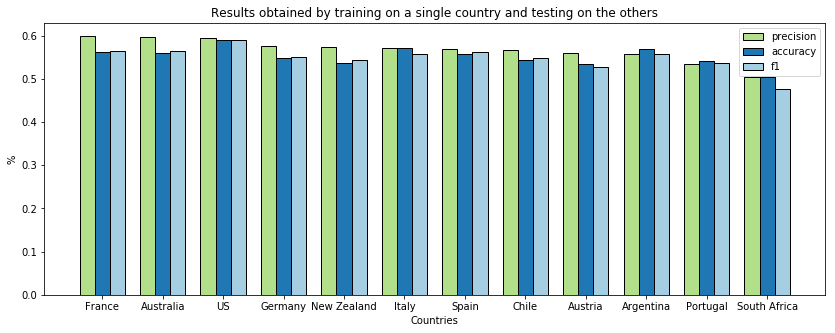

In [53]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results obtained by training on a single country and testing on the others")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


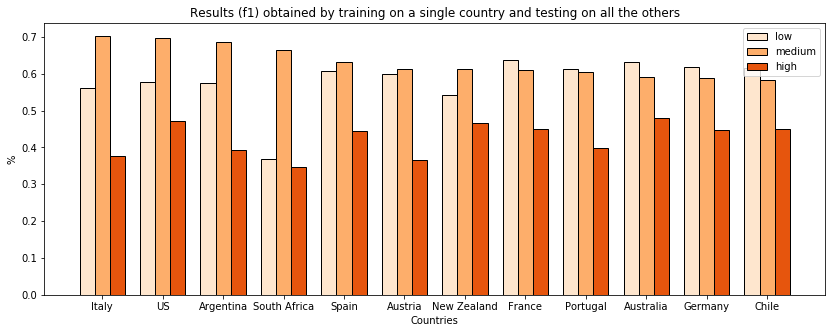

In [55]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_f1","medium_f1","high_f1"]]
temp = temp.sort_values(["medium_f1","high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Results (f1) obtained by training on a single country and testing on all the others") 
# Show graphic
plt.show()

In [56]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = trainedOnSingleCountry.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

['feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Christina Pickard', 'feat_Fiona Adams', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Matt Kettmann', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_Sean P. Sullivan', 'feat_Susan Kostrzewa', 'feat_Virginie Boone', 'feat_unknown']


,ObjectiveCountry,feat_price,feat_variety,feat_similarityTop3WinesByVariety,feat_word_count,feat_vintage,feat_Alexander Peartree,feat_Anna Lee C. Iijima,feat_Anne Krebiehl MW,feat_Carrie Dykes,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,Argentina,0.799905,0.007783,0.136787,0.048371,0.007154,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Australia,0.746647,0.004640,0.092457,0.086830,0.068271,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Austria,0.528407,0.015658,0.030884,0.315593,0.021845,0.000000,0.0,0.078793,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.008821,0.000000,0.000000,0.000000,0.000000
3,Chile,0.865228,0.007292,0.039091,0.077142,0.010854,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000394
4,France,0.835284,0.001818,0.056300,0.097119,0.000289,0.000000,0.0,0.007428,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000316,0.000000,0.000000,0.000000,0.001174
5,Germany,0.759795,0.015037,0.096134,0.056995,0.072039,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Italy,0.698954,0.000810,0.063479,0.208431,0.000783,0.000000,0.0,0.000000,0.0,...,0.024076,0.000000,0.0,0.000000,0.000000,0.000113,0.000000,0.000000,0.000000,0.003354
7,New Zealand,0.524842,0.010128,0.045277,0.287067,0.121151,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009433
8,Portugal,0.786935,0.031869,0.089172,0.083562,0.008195,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000266,0.000000,0.000000,0.000000,0.000000
9,South Africa,0.581284,0.006894,0.024863,0.352734,0.014024,0.000000,0.0,0.000000,0.0,...,0.000000,0.004066,0.0,0.000000,0.000000,0.000000,0.000000,0.004712,0.000000,0.011425


['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_vintage']
[0.23491982801401204, 1.0000000000000002, 0.05680174665156988]


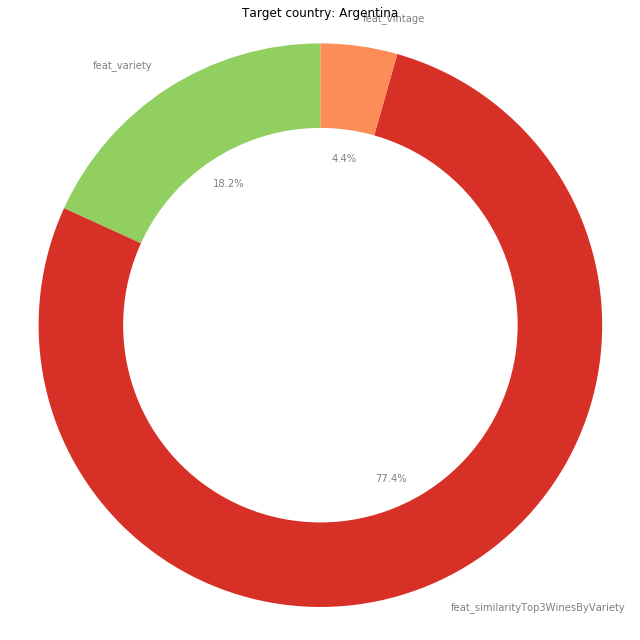

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Joe Czerwinski']
[0.13508132085498195, 0.6334726496857667, 0.10946333225500915, 0.5624715157375562, 0.5498676228123301]


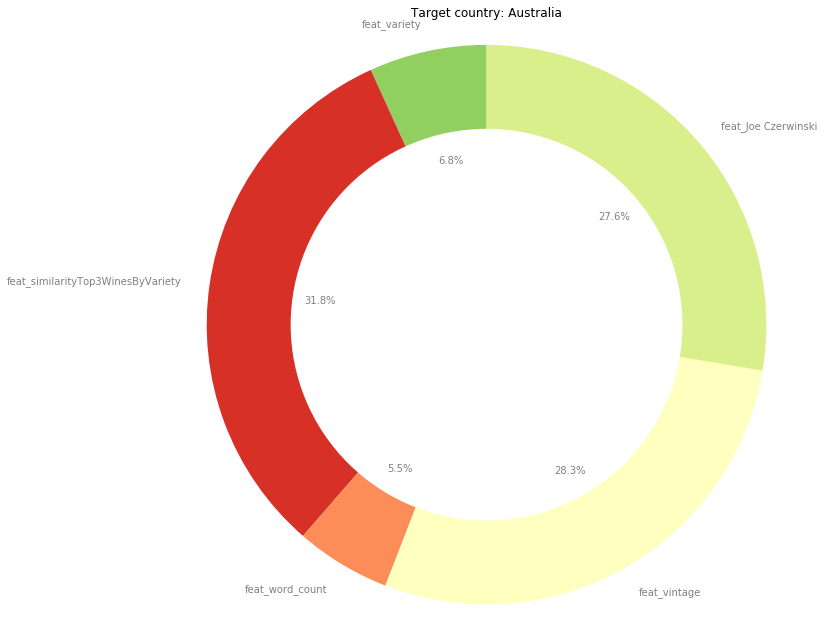

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anne Krebiehl\xa0MW', 'feat_Roger Voss']
[0.485069003983852, 0.1243820422868783, 0.7605664132256901, 0.17835162301783303, 1.0, 1.0]


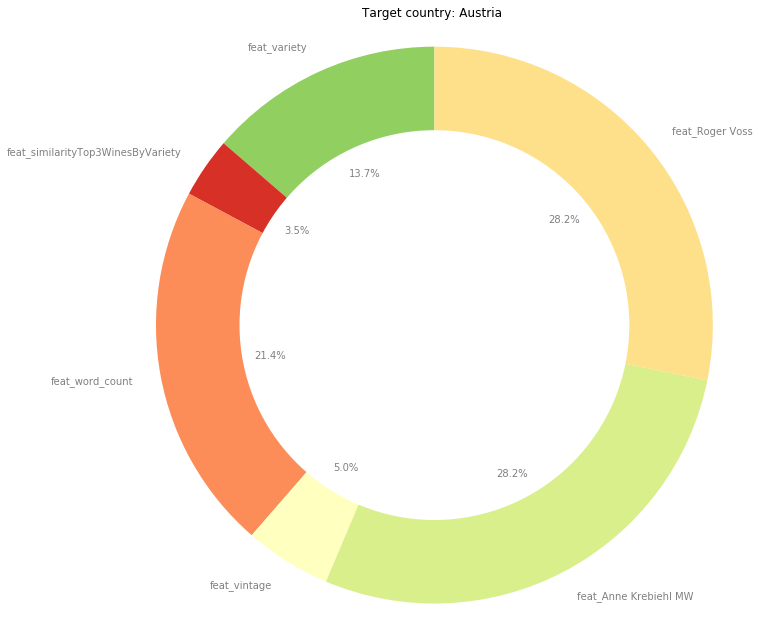

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_unknown']
[0.21931358537053147, 0.19224170866309018, 0.08188805666292379, 0.08742048473335688, 0.0051041551234722185]


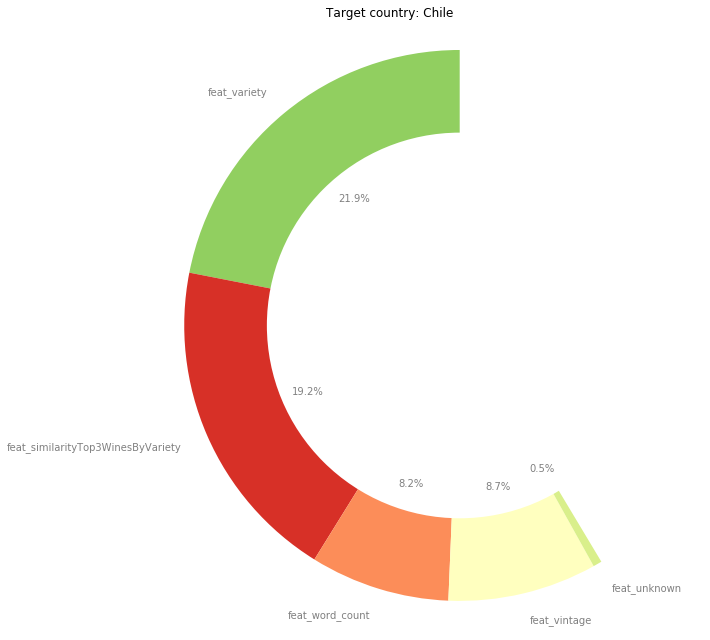

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_Anne Krebiehl\xa0MW', 'feat_Joe Czerwinski', 'feat_Roger Voss', 'feat_unknown']
[0.04545844597986215, 0.3345242235606738, 0.13874731592278897, 0.0942678495822998, 0.1295805618627037, 0.03586336901701181, 0.015216879671225014]


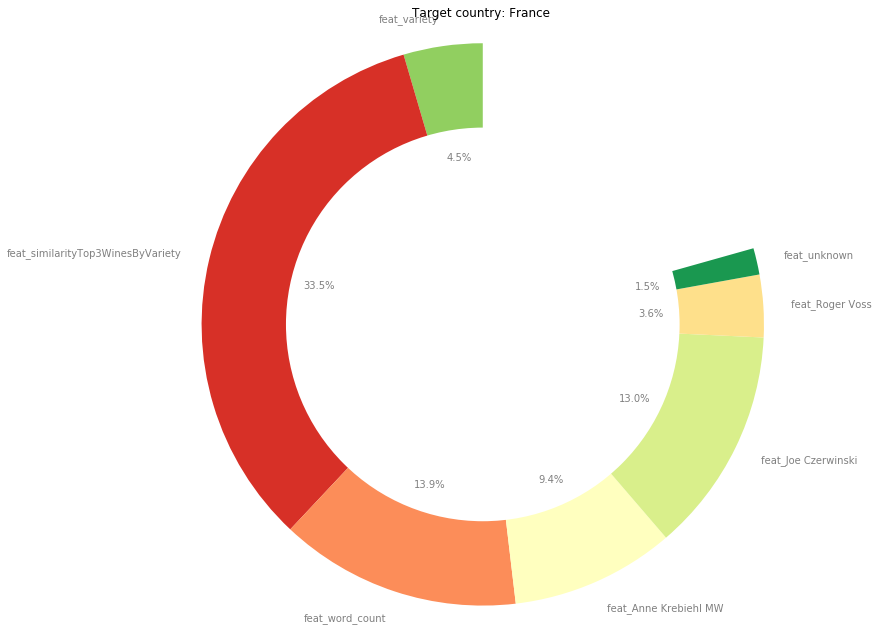

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage']
[0.4653427567682962, 0.6638734871767588, 0.02454839087835406, 0.5936529784171297]


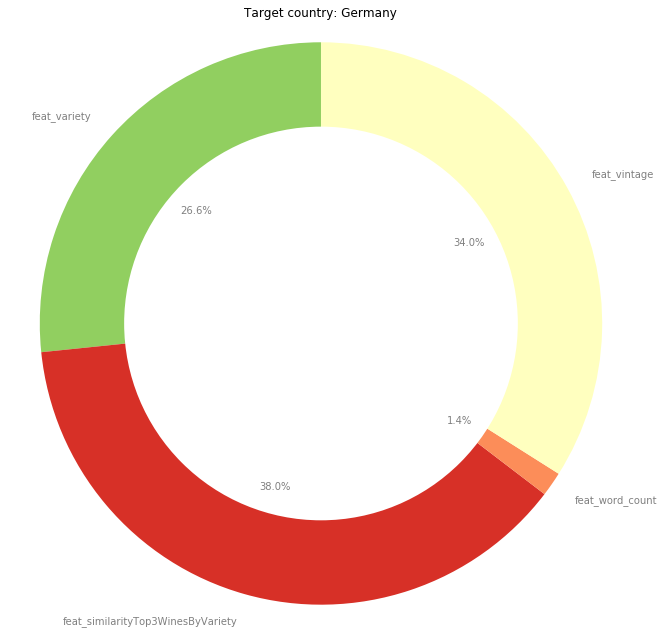

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Kerin O’Keefe', 'feat_Roger Voss', 'feat_unknown']
[0.013426888017431644, 0.39388645068058636, 0.45556248177542247, 0.00408920083597868, 1.0, 0.012850883001364069, 0.04345766439378192]


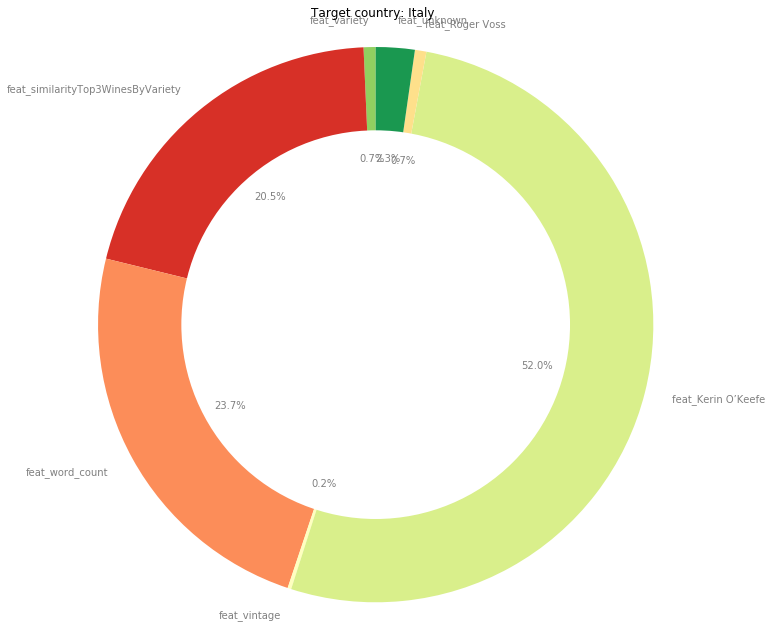

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Joe Czerwinski', 'feat_unknown']
[0.309395201979626, 0.24338557591967483, 0.6793761239004209, 1.0, 1.0, 0.12223324821118473]


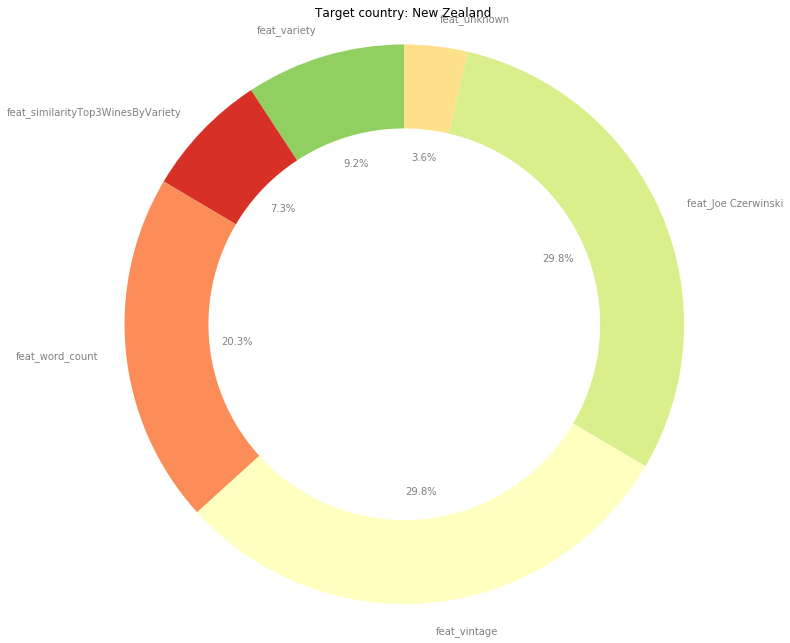

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Roger Voss']
[1.0, 0.606316994288302, 0.10016226256789043, 0.06541792204618775, 0.030139518707977247]


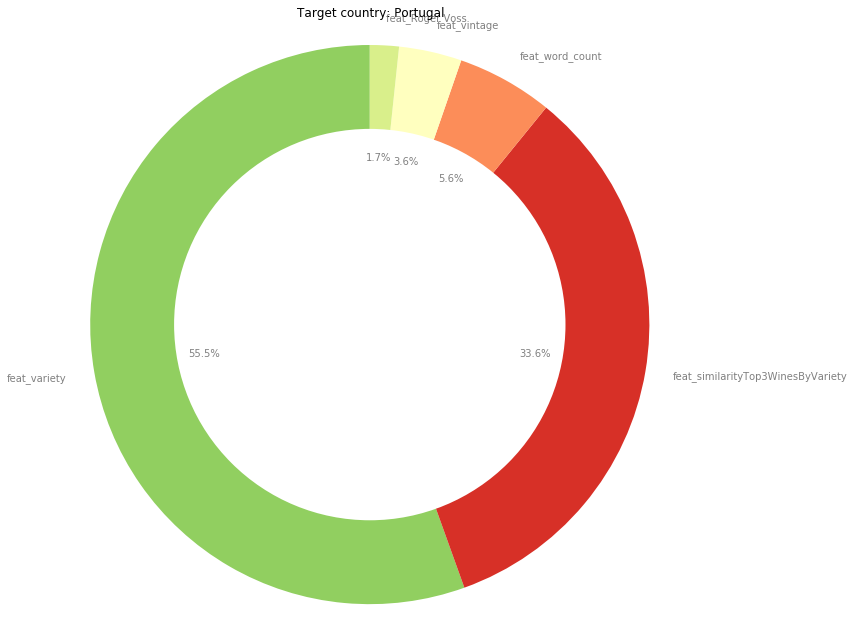

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Lauren Buzzeo', 'feat_Susan Kostrzewa', 'feat_unknown']
[0.2066772242374978, 0.07460008343103092, 0.8662773444028009, 0.11364113786882418, 1.0, 1.0, 0.14804017561715693]


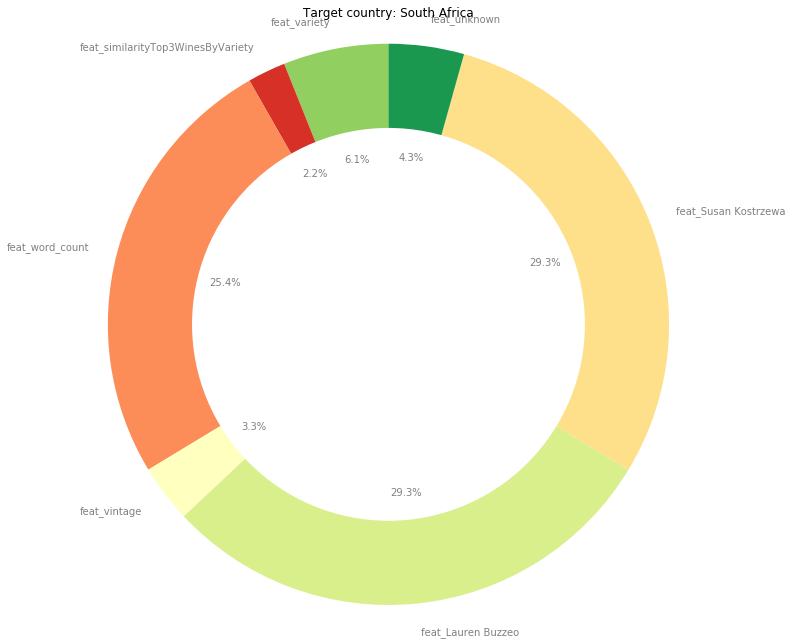

['feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Michael Schachner', 'feat_unknown']
[0.28275476707838, 0.35303397462685715, 0.10506692438255677, 0.07014428143932158, 1.0, 0.002927596803706211]


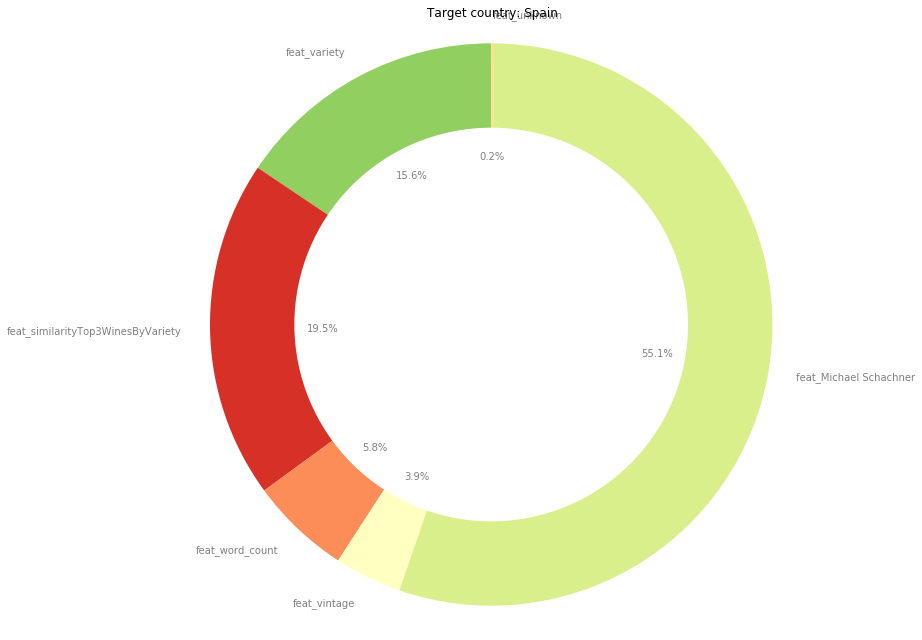

['feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Paul Gregutt', 'feat_Sean P. Sullivan', 'feat_Virginie Boone', 'feat_unknown']
[1.0, 0.05933166124269673, 1.0, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0]


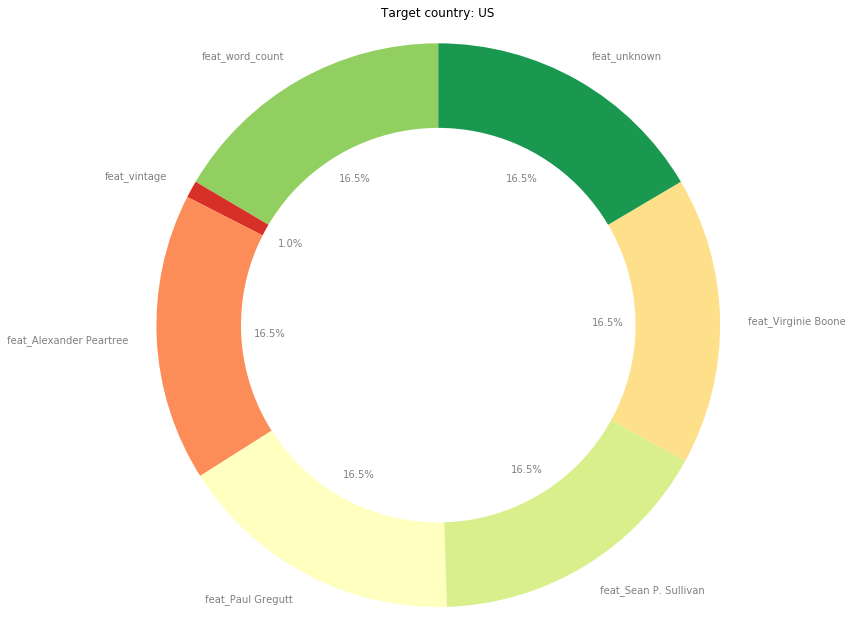

In [57]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

[['feat_vintage', 0.05680174665156988], ['feat_variety', 0.23491982801401204], ['feat_price', 0.8221334109066956], ['feat_similarityTop3WinesByVariety', 1.0000000000000002]]


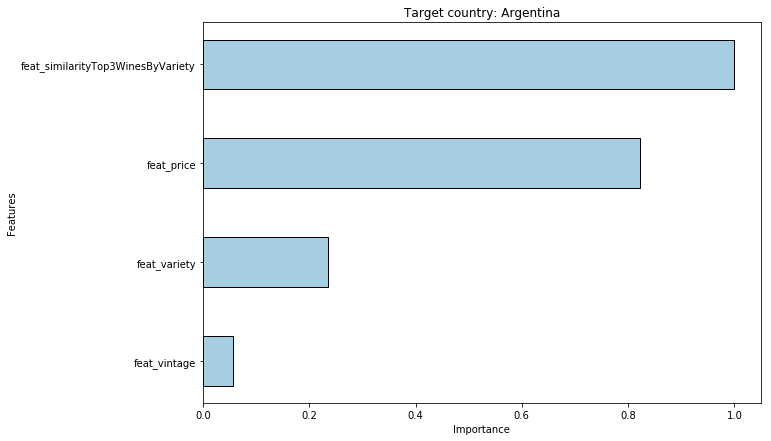

[['feat_word_count', 0.10946333225500915], ['feat_variety', 0.13508132085498195], ['feat_Joe Czerwinski', 0.5498676228123301], ['feat_vintage', 0.5624715157375562], ['feat_similarityTop3WinesByVariety', 0.6334726496857667], ['feat_price', 0.6771153134859447]]


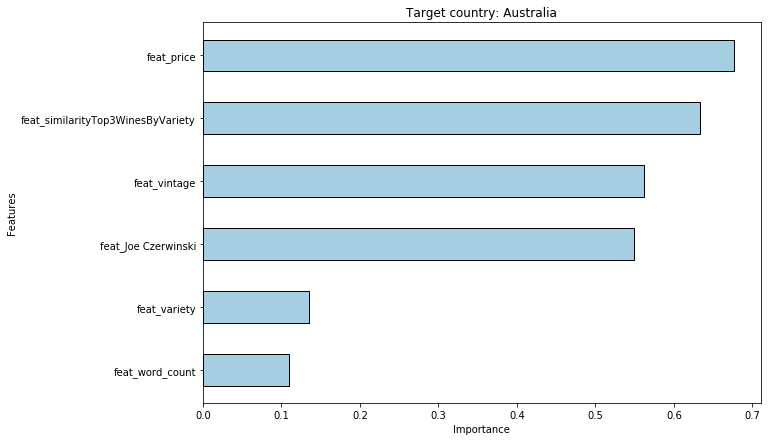

[['feat_price', 0.08286668113023166], ['feat_similarityTop3WinesByVariety', 0.1243820422868783], ['feat_vintage', 0.17835162301783303], ['feat_variety', 0.485069003983852], ['feat_word_count', 0.7605664132256901], ['feat_Anne Krebiehl\xa0MW', 1.0], ['feat_Roger Voss', 1.0]]


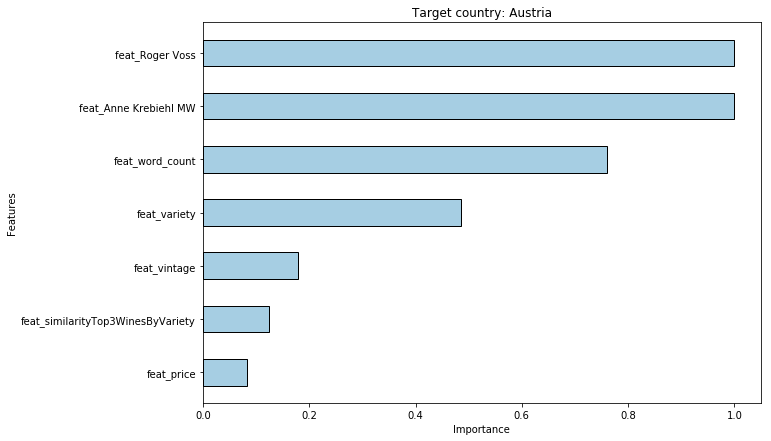

[['feat_unknown', 0.0051041551234722185], ['feat_word_count', 0.08188805666292379], ['feat_vintage', 0.08742048473335688], ['feat_similarityTop3WinesByVariety', 0.19224170866309018], ['feat_variety', 0.21931358537053147], ['feat_price', 1.0000000000000002]]


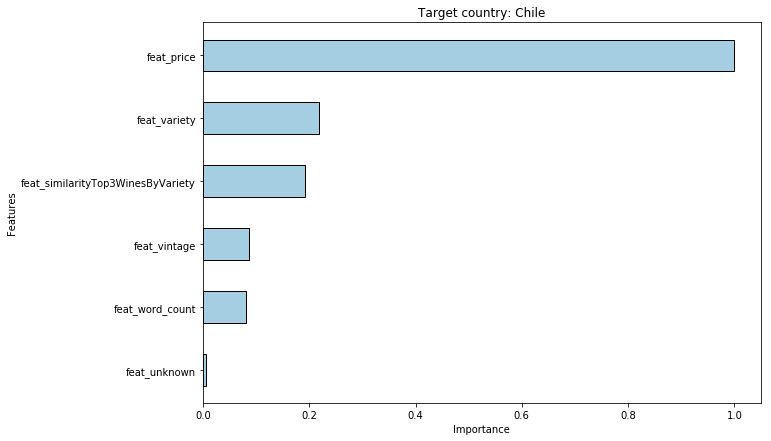

[['feat_unknown', 0.015216879671225014], ['feat_Roger Voss', 0.03586336901701181], ['feat_variety', 0.04545844597986215], ['feat_Anne Krebiehl\xa0MW', 0.0942678495822998], ['feat_Joe Czerwinski', 0.1295805618627037], ['feat_word_count', 0.13874731592278897], ['feat_similarityTop3WinesByVariety', 0.3345242235606738], ['feat_price', 0.9184660012546664]]


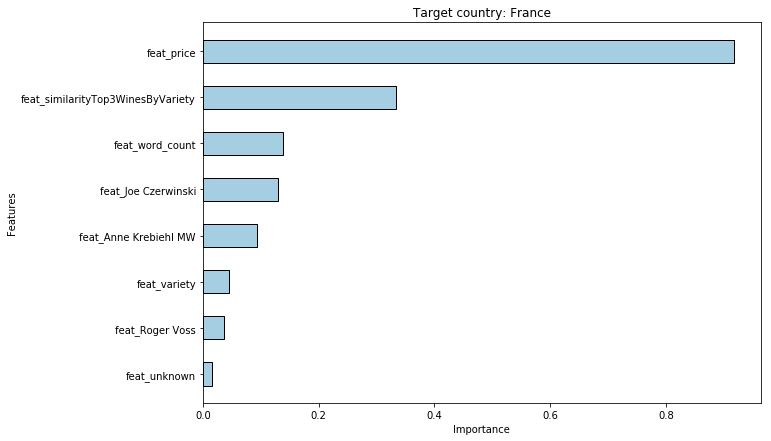

[['feat_word_count', 0.02454839087835406], ['feat_variety', 0.4653427567682962], ['feat_vintage', 0.5936529784171297], ['feat_similarityTop3WinesByVariety', 0.6638734871767588], ['feat_price', 0.7129147615974138]]


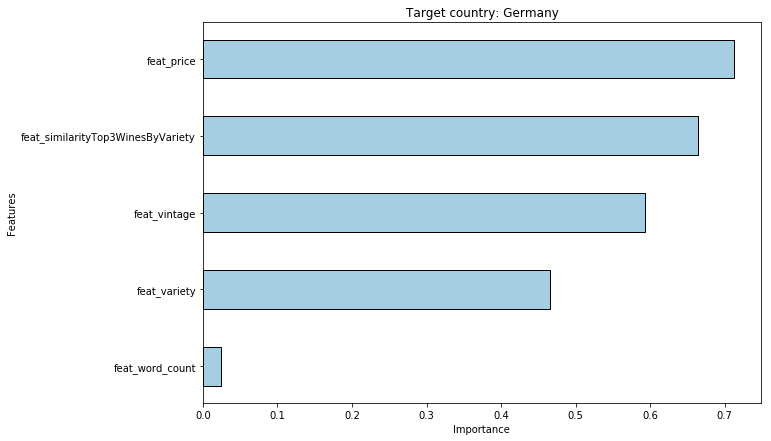

[['feat_vintage', 0.00408920083597868], ['feat_Roger Voss', 0.012850883001364069], ['feat_variety', 0.013426888017431644], ['feat_unknown', 0.04345766439378192], ['feat_similarityTop3WinesByVariety', 0.39388645068058636], ['feat_word_count', 0.45556248177542247], ['feat_price', 0.5472500170508394], ['feat_Kerin O’Keefe', 1.0]]


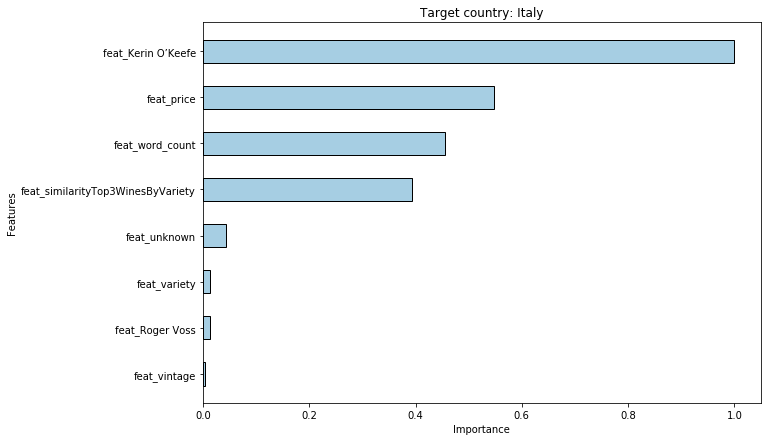

[['feat_price', 0.07315913022692766], ['feat_unknown', 0.12223324821118473], ['feat_similarityTop3WinesByVariety', 0.24338557591967483], ['feat_variety', 0.309395201979626], ['feat_word_count', 0.6793761239004209], ['feat_vintage', 1.0], ['feat_Joe Czerwinski', 1.0]]


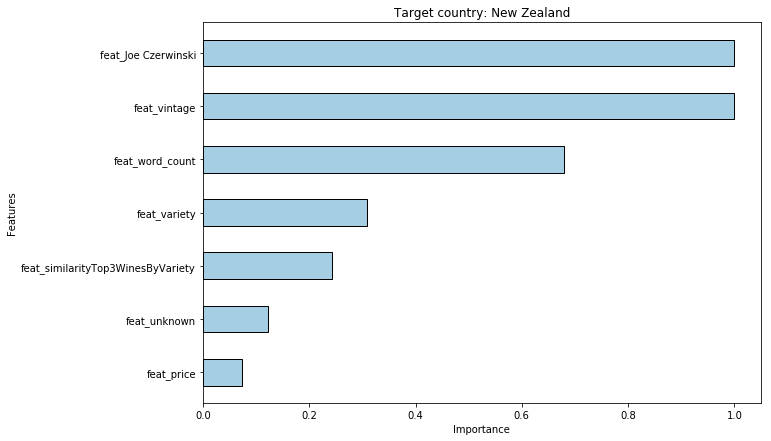

[['feat_Roger Voss', 0.030139518707977247], ['feat_vintage', 0.06541792204618775], ['feat_word_count', 0.10016226256789043], ['feat_similarityTop3WinesByVariety', 0.606316994288302], ['feat_price', 0.7868170762202797], ['feat_variety', 1.0]]


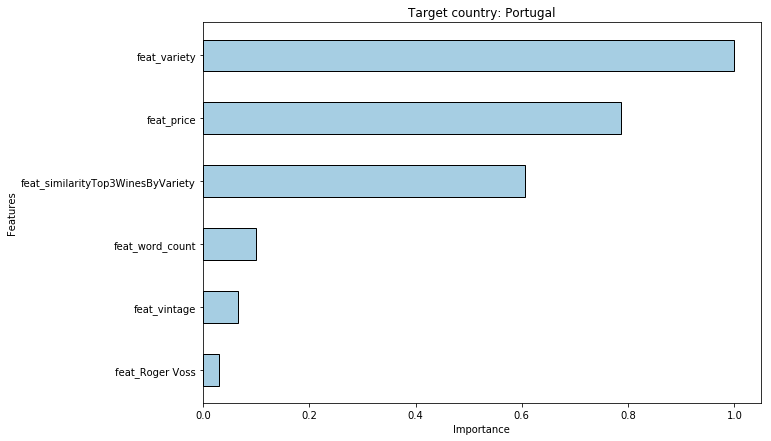

[['feat_similarityTop3WinesByVariety', 0.07460008343103092], ['feat_vintage', 0.11364113786882418], ['feat_unknown', 0.14804017561715693], ['feat_variety', 0.2066772242374978], ['feat_price', 0.22684386292453507], ['feat_word_count', 0.8662773444028009], ['feat_Lauren Buzzeo', 1.0], ['feat_Susan Kostrzewa', 1.0]]


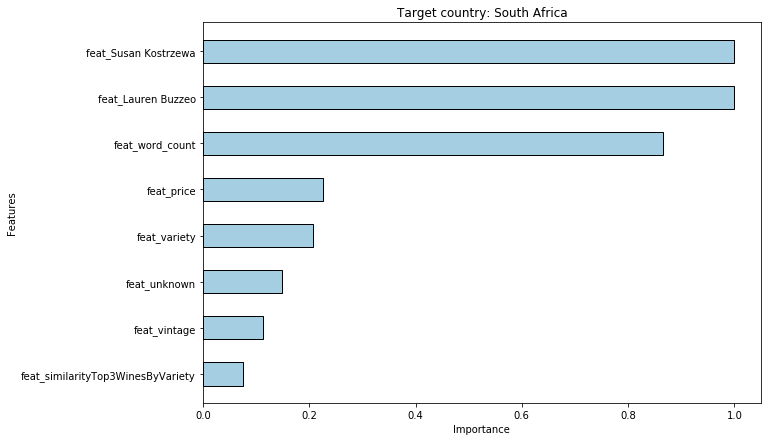

[['feat_unknown', 0.002927596803706211], ['feat_vintage', 0.07014428143932158], ['feat_word_count', 0.10506692438255677], ['feat_variety', 0.28275476707838], ['feat_similarityTop3WinesByVariety', 0.35303397462685715], ['feat_price', 0.9249986750071344], ['feat_Michael Schachner', 1.0]]


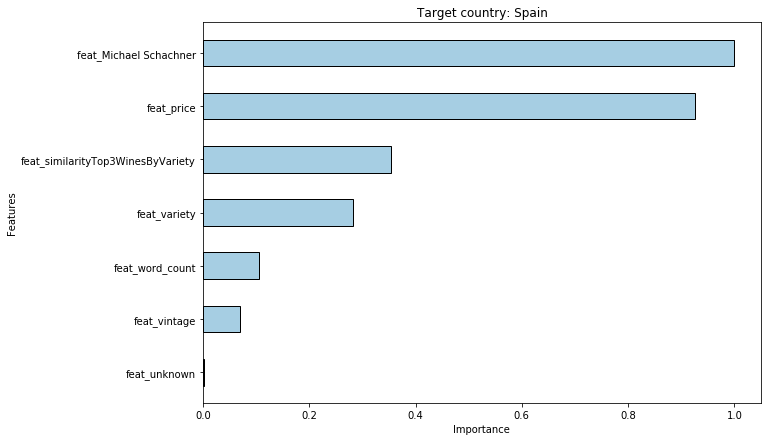

[['feat_vintage', 0.05933166124269673], ['feat_Paul Gregutt', 0.9999999999999999], ['feat_Sean P. Sullivan', 0.9999999999999999], ['feat_Virginie Boone', 0.9999999999999999], ['feat_word_count', 1.0], ['feat_Alexander Peartree', 1.0], ['feat_unknown', 1.0]]


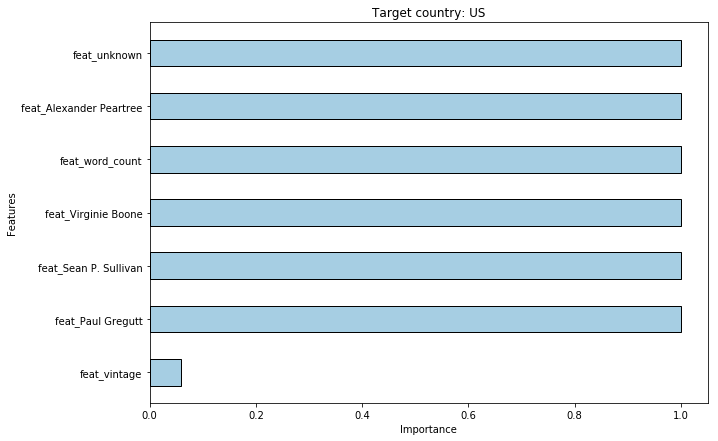

In [58]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# DUMMY (train one country, test others)

In [ ]:
for c in countries:
    X = wine_base
    wine_base["category"] = Y
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X[X["country"] == c]
    y_train = list(X_train["category"])
    print(c +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
    print(str(X_train["country"].unique().tolist()) + "country in the training set")
    X_train.drop(["country","category"],axis=1,inplace=True)

    X_test = X[X["country"] != c]
    y_test = X_test["category"]
    print(str(X_test["country"].unique().tolist()) + "country in the test set")
    X_test.drop(["country","category"],axis=1,inplace=True)
   
    classifier = DummyClassifier("stratified")
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print("COUNTRY " + c + classification_report(y_test, y_pred, target_names=labels))


# train on one, test on one

In [80]:
def trainByCountry2(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest2(wine3,el)
        df = df.append(res)
    return df

def applyTest2(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult2(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult2(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth","combination"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    print(cols)
    for el in combination["args"]: 
        print(data["country"].unique().tolist())
        countries = data["country"].unique().tolist()
        interestingC =[]
        for gg in countries:
            if gg != objCountry:
                interestingC.append(gg)
      #  countries = countries.remove(objCountry) 
        print(interestingC)
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        for countr in interestingC:
            X_test = X[X["country"] == countr]
            y_test = X_test["category"]
            print(str(X_test["country"].unique().tolist()) + "country in the test set")
            X_test.drop(["country","category"],axis=1,inplace=True)
            for depth in combination["depth"]:
                    row = row + 1  
                    #train stuff
                    classifier = DecisionTreeClassifier(max_depth=depth)
                    classifier.fit(X_train,y_train)
                    y_pred = classifier.predict(X_test)  
                    acc = accuracy_score(y_test,y_pred)#average="macro")
                    weightedPrec = precision_score(y_test,y_pred,average="weighted")
                    f1 = f1_score(y_test,y_pred,average="weighted")
                    nations = objCountry +"->"+countr
                    rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth,nations]
                    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                    for i in range(0,len(labels)):
                        rowData.append(precision[i])
                        rowData.append(recall[i])
                        rowData.append(fscore[i])
                        rowData.append(support[i])
                        temp = {}
                    c = zip(el,classifier.feature_importances_)
                    names = []
                    for name,importance in c:
                        temp[name] = importance
                        names.append(name)
                    for feat in names:
                        #if feat not in allfeatures:
                         #   rowData.append(100) #100 is an impossible value not to be taken into account
                        #else:
                            rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                    df2 = pd.DataFrame([rowData],columns=cols)
                    results = results.append(df2,ignore_index=True)
            comb = comb + 1
    return results

In [81]:
twoComb = trainByCountry2(wine_base,countries)
twoComb.drop("input",inplace=True,axis=1)
twoComb

['algorithm', 'ObjectiveCountry', 'input', 'precision', 'accuracy', 'f1', 'depth', 'combination', 'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec', 'medium_recall', 'medium_f1', 'medium_support', 'high_prec', 'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Christina Pickard', 'feat_Fiona Adams', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Matt Kettmann', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_Sean P. Sullivan', 'feat_Susan Kostrzewa', 'feat_Virginie Boone', 'feat_unknown']
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', '

['Portugal']country in the test set
['US']country in the test set
['Spain']country in the test set
['France']country in the test set
['Argentina']country in the test set
['Chile']country in the test set
['Australia']country in the test set
['Austria']country in the test set
['South Africa']country in the test set
['New Zealand']country in the test set
['algorithm', 'ObjectiveCountry', 'input', 'precision', 'accuracy', 'f1', 'depth', 'combination', 'low_prec', 'low_recall', 'low_f1', 'low_support', 'medium_prec', 'medium_recall', 'medium_f1', 'medium_support', 'high_prec', 'high_recall', 'high_f1', 'high_support', 'feat_price', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Christina Pickard', 'feat_Fiona Adams', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Matt Kettmann', 'feat_Michael Schach

['Portugal']country in the test set
['US']country in the test set
['Spain']country in the test set
['France']country in the test set
['Germany']country in the test set
['Argentina']country in the test set
['Chile']country in the test set
['Australia']country in the test set
['Austria']country in the test set
['South Africa']country in the test set


,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,combination,low_prec,low_recall,low_f1,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Italy,0.550016,0.504848,0.436119,2,Italy->Portugal,0.862434,0.130504,0.226704,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,decTree,Italy,0.578199,0.506869,0.432955,3,Italy->Portugal,0.913043,0.067254,0.125280,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,decTree,Italy,0.571260,0.553333,0.512690,4,Italy->Portugal,0.800885,0.289832,0.425632,...,0.036427,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,decTree,Italy,0.570470,0.557778,0.513446,5,Italy->Portugal,0.797826,0.293835,0.429491,...,0.042116,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008115
4,decTree,Italy,0.575202,0.557980,0.515623,6,Italy->Portugal,0.810268,0.290633,0.427814,...,0.040675,0.0,0.0,0.0,0.0,0.000567,0.0,0.0,0.0,0.007568
5,decTree,Italy,0.533606,0.524925,0.526633,2,Italy->US,0.660543,0.533101,0.590019,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
6,decTree,Italy,0.619721,0.506027,0.497581,3,Italy->US,0.816210,0.233928,0.363636,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
7,decTree,Italy,0.535365,0.504008,0.505079,4,Italy->US,0.664481,0.373847,0.478489,...,0.036427,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
8,decTree,Italy,0.564332,0.561106,0.555594,5,Italy->US,0.672372,0.488488,0.565866,...,0.042116,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008115
9,decTree,Italy,0.565673,0.555493,0.552583,6,Italy->US,0.694453,0.481519,0.568708,...,0.040675,0.0,0.0,0.0,0.0,0.000567,0.0,0.0,0.0,0.007568


In [107]:
temp1 = pd.DataFrame()
feats=[]
for f in twoComb.columns:
    if f != "algorithm" and f != "ObjectiveCountry" and f != "depth":
        feats.append(f)
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby("combination")
t2 =pd.DataFrame()
for col in feats:
    if col != "combination":
        t2[col] = temp1[col].mean()

t2.reset_index(inplace=True)
t2

,combination,precision,accuracy,f1,low_prec,low_recall,low_f1,low_support,medium_prec,medium_recall,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,Argentina->Australia,0.569009,0.562723,0.534997,0.690357,0.523368,0.589397,582,0.560142,0.852284,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Argentina->Austria,0.541810,0.410280,0.418150,0.785167,0.386039,0.515928,1318,0.253941,0.806019,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Argentina->Chile,0.711823,0.732772,0.712158,0.558378,0.565782,0.560818,339,0.804279,0.898632,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Argentina->France,0.552339,0.551158,0.533682,0.666684,0.545433,0.596999,5956,0.591520,0.753591,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Argentina->Germany,0.587089,0.548938,0.551265,0.719742,0.612929,0.661670,758,0.384591,0.725000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Argentina->Italy,0.571104,0.561650,0.552086,0.495707,0.716837,0.583480,4009,0.667672,0.642328,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Argentina->New Zealand,0.523992,0.506309,0.457804,0.621796,0.412451,0.487729,257,0.499918,0.851534,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Argentina->Portugal,0.587514,0.593374,0.564537,0.718347,0.443235,0.548140,1249,0.627964,0.886378,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Argentina->South Africa,0.598742,0.611682,0.586656,0.589160,0.461472,0.516576,231,0.664683,0.869949,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Argentina->Spain,0.647435,0.653929,0.648758,0.609563,0.621838,0.614073,925,0.756823,0.791178,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


             combination        f1
113         Spain->Chile  0.739392
2       Argentina->Chile  0.712158
102  South Africa->Chile  0.711922
47         France->Chile  0.710279
110     Spain->Argentina  0.704787
33      Chile->Argentina  0.696104
69          Italy->Chile  0.691102
66      Italy->Argentina  0.672686
44     France->Argentina  0.671004
13      Australia->Chile  0.652181


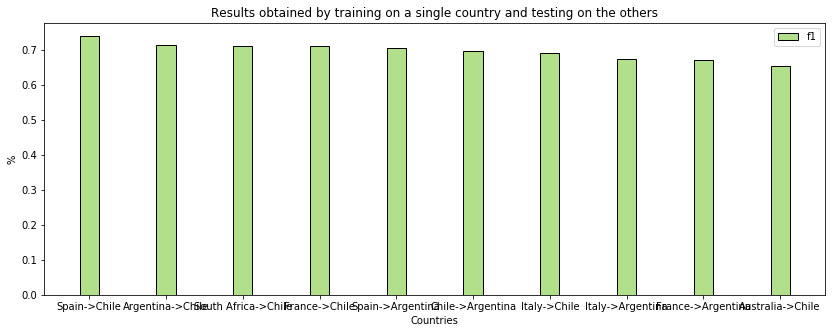

In [133]:
temp = pd.DataFrame()
temp = t2.loc[:,["combination","f1"]]
temp = temp.sort_values(["f1"],ascending=False)
temp = temp.head(10)
print(temp)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
#bars1 = temp["precision"]
# Choose the height of the cyan bars
#bars2 = temp["accuracy"]

bars1 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
#r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1,bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='f1')
 
# Create cyan bars
#plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

#plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["combination"].tolist()
# general layout
plt.xticks([r for r in range(len(bars1))], xs)
plt.title("Results obtained by training on a single country and testing on the others")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


             combination  precision  accuracy        f1  low_prec  low_recall  \
113         Spain->Chile   0.741240  0.744939  0.739392  0.591711    0.507965   
2       Argentina->Chile   0.711823  0.732772  0.712158  0.558378    0.565782   
102  South Africa->Chile   0.737836  0.715989  0.711922  0.594997    0.191150   
47         France->Chile   0.731573  0.712335  0.710279  0.479763    0.663717   
110     Spain->Argentina   0.712493  0.706438  0.704787  0.701557    0.532231   
33      Chile->Argentina   0.709182  0.705980  0.696104  0.762524    0.421488   
69          Italy->Chile   0.695152  0.730464  0.691102  0.605577    0.506195   
66      Italy->Argentina   0.674905  0.700944  0.672686  0.721763    0.522314   
44     France->Argentina   0.694712  0.671416  0.671004  0.563479    0.729752   
13      Australia->Chile   0.729075  0.630921  0.652181  0.472414    0.692625   

       low_f1  low_support  medium_prec  medium_recall      ...       \
113  0.545172          339     0.843

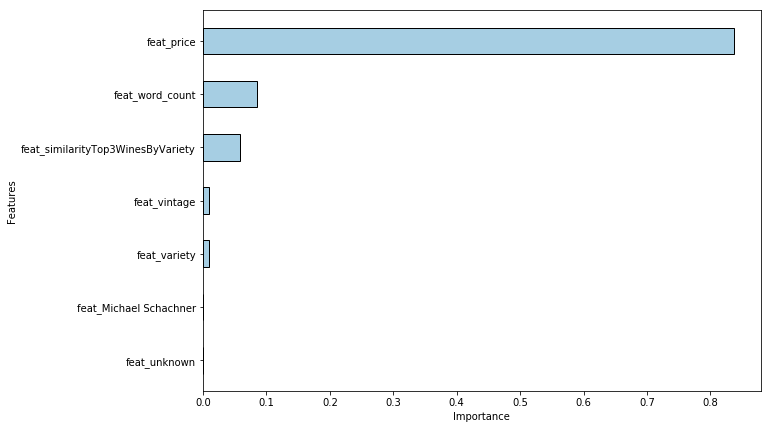

[['feat_vintage', 0.007153754140907969], ['feat_variety', 0.0077828765060102625], ['feat_word_count', 0.04900399823368294], ['feat_similarityTop3WinesByVariety', 0.13678740509598442], ['feat_price', 0.7992719660234144]]


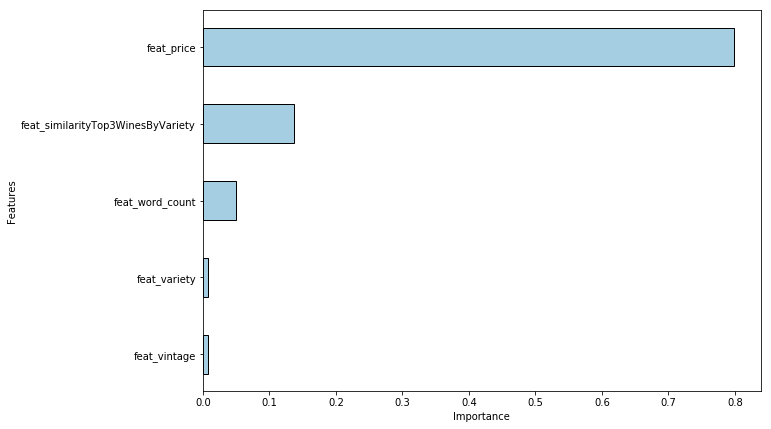

[['feat_Lauren Buzzeo', 0.0040660566627376046], ['feat_Susan Kostrzewa', 0.004711868155108125], ['feat_variety', 0.006893745985169531], ['feat_unknown', 0.012013614510305779], ['feat_vintage', 0.013957720890127593], ['feat_similarityTop3WinesByVariety', 0.024489085250982798], ['feat_word_count', 0.3525843897058131], ['feat_price', 0.5812835188397555]]


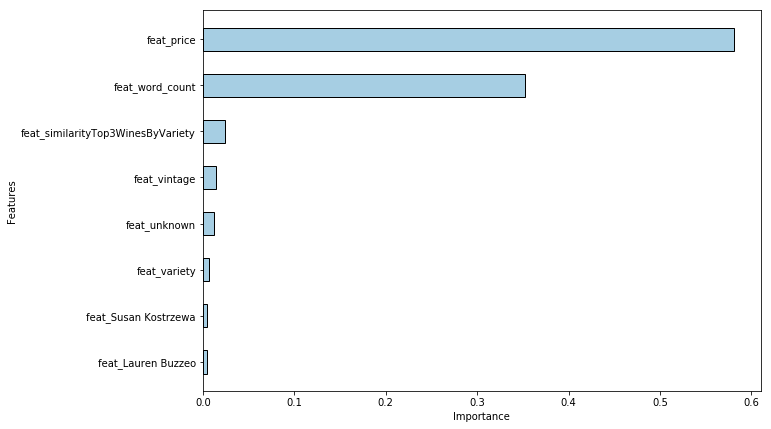

[['feat_Joe Czerwinski', 0.00027236378908168137], ['feat_vintage', 0.0002885263451697361], ['feat_Roger Voss', 0.0003163394889284216], ['feat_unknown', 0.0011743575958314142], ['feat_variety', 0.0018182742823543876], ['feat_Anne Krebiehl\xa0MW', 0.0074276456076741975], ['feat_similarityTop3WinesByVariety', 0.05629973962735739], ['feat_word_count', 0.0971188498753176], ['feat_price', 0.8352839033882852]]


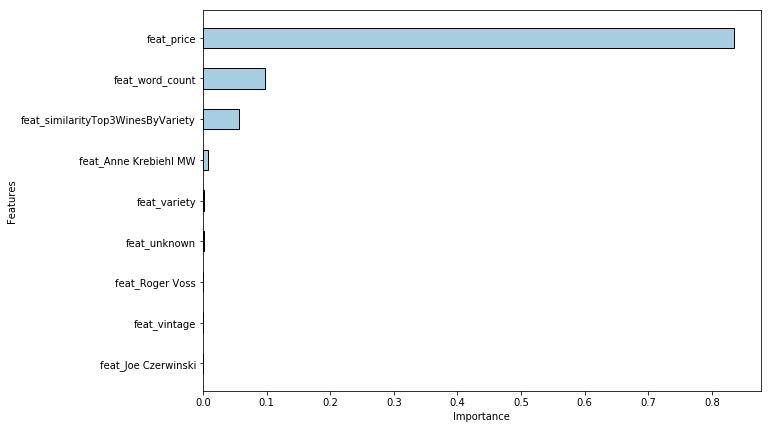

[['feat_Michael Schachner', 0.00021201197909437517], ['feat_unknown', 0.00022593630351598775], ['feat_vintage', 0.009024514858078021], ['feat_variety', 0.009030668417438539], ['feat_similarityTop3WinesByVariety', 0.05853844869005813], ['feat_word_count', 0.0852853715801323], ['feat_price', 0.8376830481716826]]


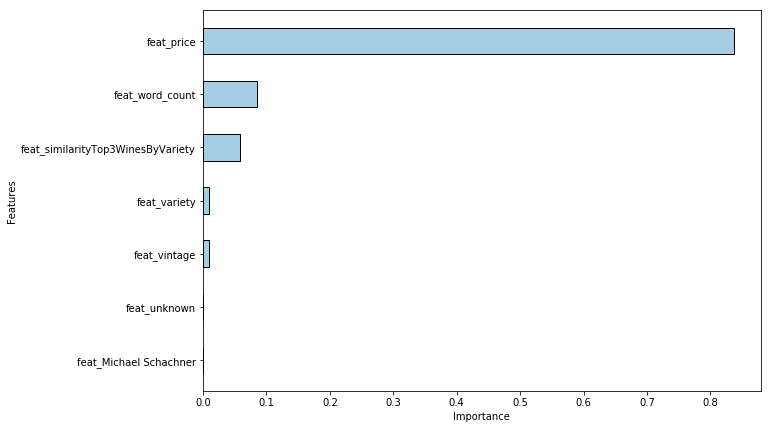

[['feat_Michael Schachner', 0.0003633378597060184], ['feat_variety', 0.007291562505369019], ['feat_vintage', 0.010884999363706922], ['feat_similarityTop3WinesByVariety', 0.03916807851464117], ['feat_word_count', 0.07706450336907274], ['feat_price', 0.8652275183875041]]


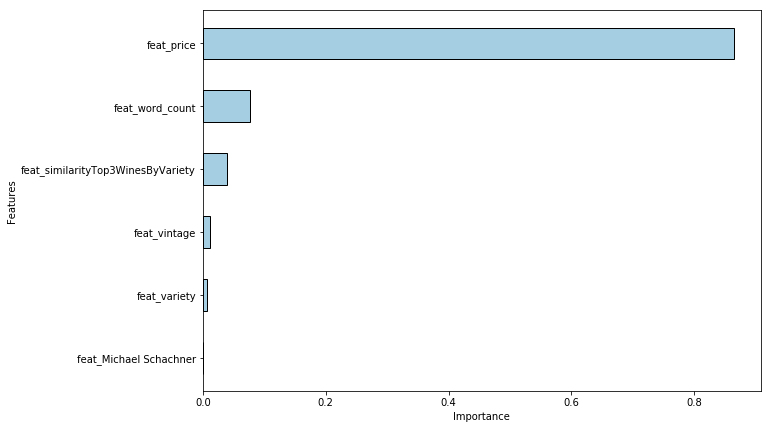

[['feat_Roger Voss', 0.00011335359371848475], ['feat_vintage', 0.0007827593027180755], ['feat_variety', 0.0008098603259131863], ['feat_unknown', 0.0033695277950414196], ['feat_Kerin O’Keefe', 0.024060705215540604], ['feat_similarityTop3WinesByVariety', 0.06347945562463202], ['feat_word_count', 0.2084306612069749], ['feat_price', 0.6989536769354613]]


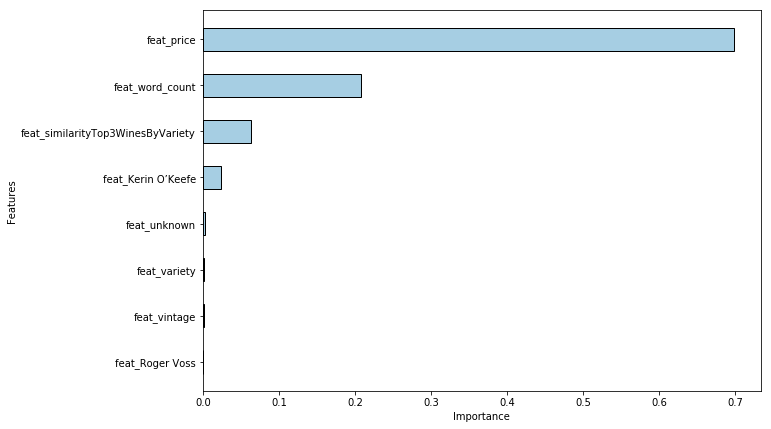

[['feat_Roger Voss', 0.00011335359371848475], ['feat_variety', 0.0008098603259131863], ['feat_vintage', 0.0010156781759267284], ['feat_unknown', 0.0031366089218327663], ['feat_Kerin O’Keefe', 0.024060705215540604], ['feat_similarityTop3WinesByVariety', 0.06347945562463202], ['feat_word_count', 0.2084306612069749], ['feat_price', 0.6989536769354613]]


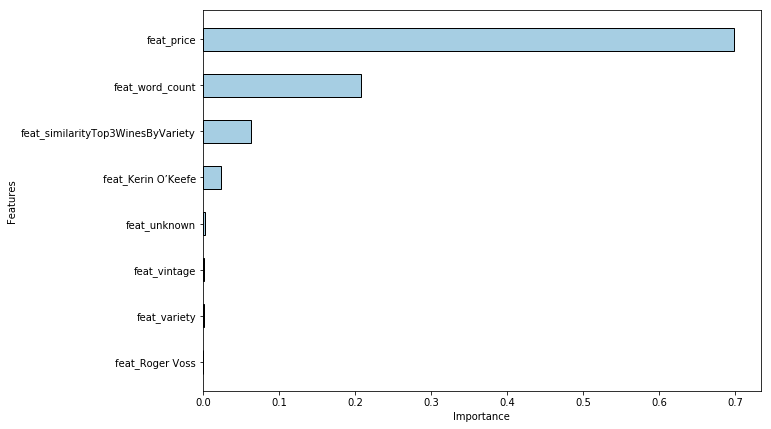

[['feat_Joe Czerwinski', 0.00027236378908168137], ['feat_Roger Voss', 0.0003163394889284216], ['feat_vintage', 0.0003573756349275963], ['feat_unknown', 0.0011743575958314142], ['feat_variety', 0.0018182742823543876], ['feat_Anne Krebiehl\xa0MW', 0.0074276456076741975], ['feat_similarityTop3WinesByVariety', 0.05623089033759952], ['feat_word_count', 0.0971188498753176], ['feat_price', 0.8352839033882852]]


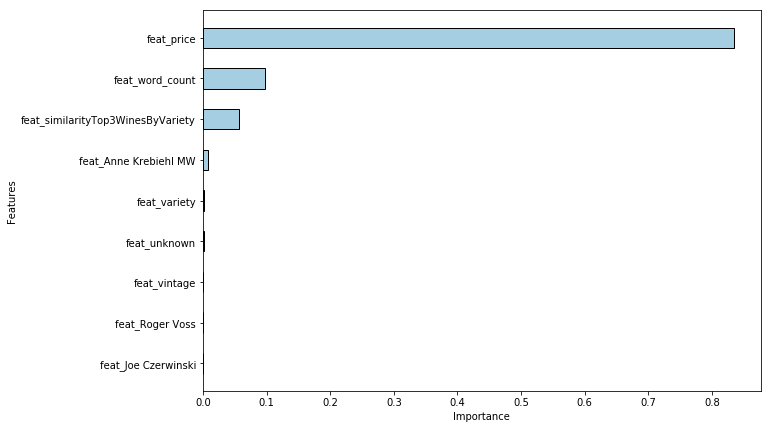

[['feat_unknown', 0.0011557599927771924], ['feat_variety', 0.004639771692703786], ['feat_vintage', 0.06827050422059412], ['feat_word_count', 0.08683003287284032], ['feat_similarityTop3WinesByVariety', 0.09197010678293219], ['feat_price', 0.7471338244381525]]


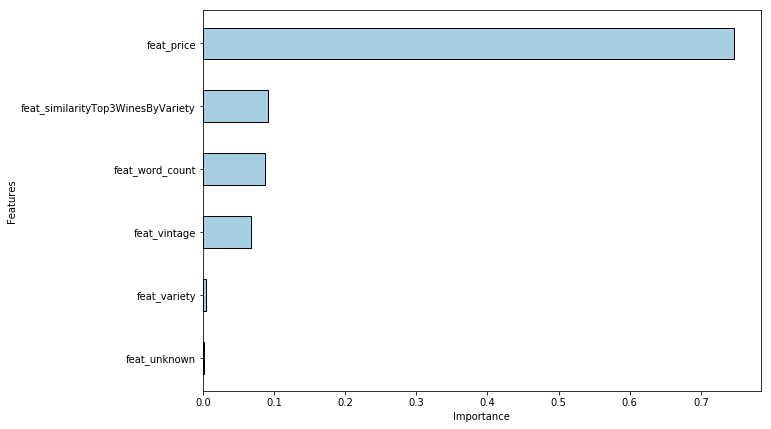

In [131]:
temp = t2
temp = temp.sort_values(["f1"],ascending=False)
temp = temp.head(10)
print(temp)
for idx,row in temp.iterrows():
    both = []
    for col in temp.columns:
        if row[col] != 0 and col != "combination" and col.startswith("feat"): #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    #plt.title("Target country: "+ temp.iloc[idx]["combination"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

                combination  precision  accuracy        f1  low_prec  \
109        South Africa->US   0.563936  0.468441  0.416999  0.769560   
37           Chile->Germany   0.530347  0.419717  0.413057  0.776508   
71           Italy->Germany   0.515859  0.406067  0.398598  0.775841   
112          Spain->Austria   0.572841  0.394259  0.393449  0.863764   
107  South Africa->Portugal   0.541522  0.477697  0.372702  0.856597   
68           Italy->Austria   0.561937  0.357877  0.354958  0.871267   
103    South Africa->France   0.547280  0.411901  0.319026  0.867586   
35           Chile->Austria   0.541334  0.329506  0.302334  0.852115   
104   South Africa->Germany   0.509235  0.336704  0.275004  0.742807   
101   South Africa->Austria   0.555807  0.290921  0.235945  0.904709   

     low_recall    low_f1  low_support  medium_prec  medium_recall  \
109    0.139824  0.216722        14637     0.587677       0.709917   
37     0.342744  0.454459          758     0.312432       0.794767 

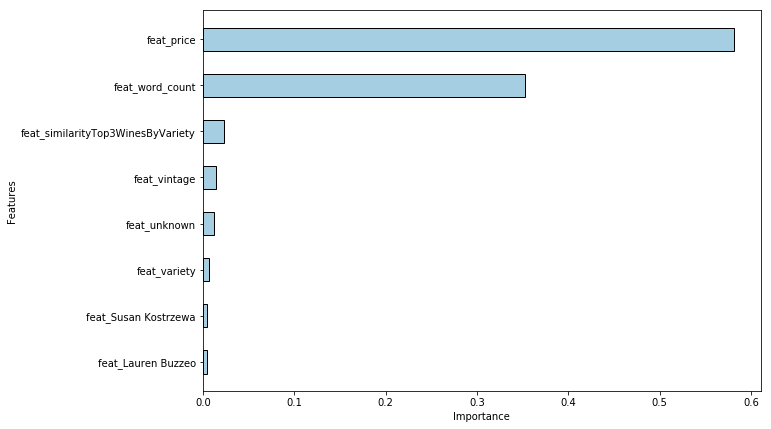

[['feat_unknown', 0.0003633378597060184], ['feat_Michael Schachner', 0.000393911463391948], ['feat_variety', 0.007291562505369019], ['feat_vintage', 0.010111507531817434], ['feat_similarityTop3WinesByVariety', 0.03855480686046059], ['feat_word_count', 0.07805735539175085], ['feat_price', 0.8652275183875041]]


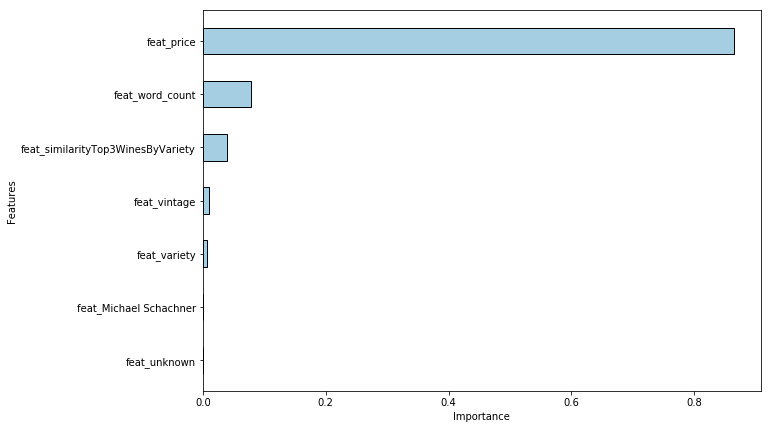

[['feat_Roger Voss', 0.00011335359371848473], ['feat_vintage', 0.0007827593027180753], ['feat_variety', 0.0008098603259131861], ['feat_unknown', 0.0035867495783588436], ['feat_Kerin O’Keefe', 0.02384348343222318], ['feat_similarityTop3WinesByVariety', 0.06347945562463202], ['feat_word_count', 0.2084306612069749], ['feat_price', 0.6989536769354613]]


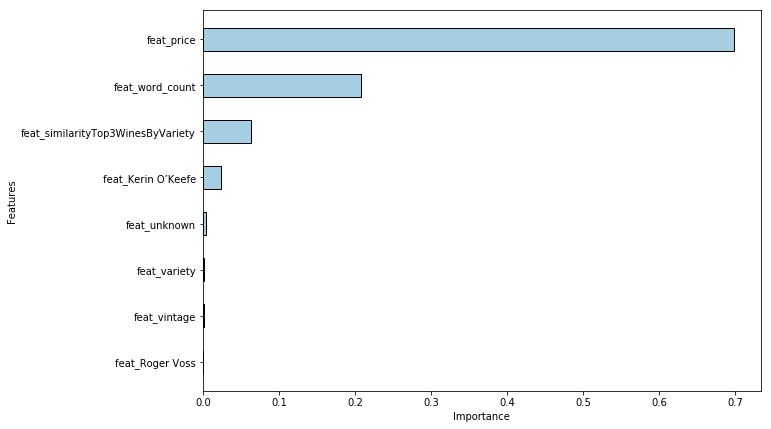

[['feat_unknown', 0.00043794828261036286], ['feat_vintage', 0.008766372521331412], ['feat_variety', 0.00911381583988987], ['feat_similarityTop3WinesByVariety', 0.05871344360435341], ['feat_word_count', 0.0852853715801323], ['feat_price', 0.8376830481716826]]


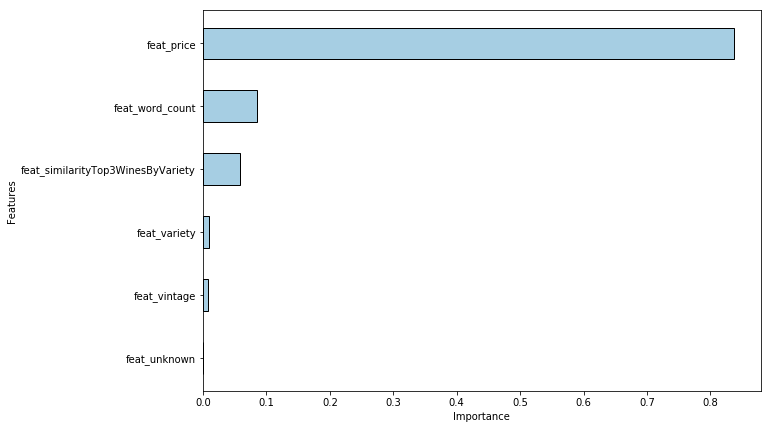

[['feat_Lauren Buzzeo', 0.0040660566627376046], ['feat_Susan Kostrzewa', 0.004711868155108124], ['feat_variety', 0.006893745985169531], ['feat_unknown', 0.011947803629778004], ['feat_vintage', 0.014023531770655365], ['feat_similarityTop3WinesByVariety', 0.025385404032768], ['feat_word_count', 0.3509909340937505], ['feat_price', 0.5819806556700329]]


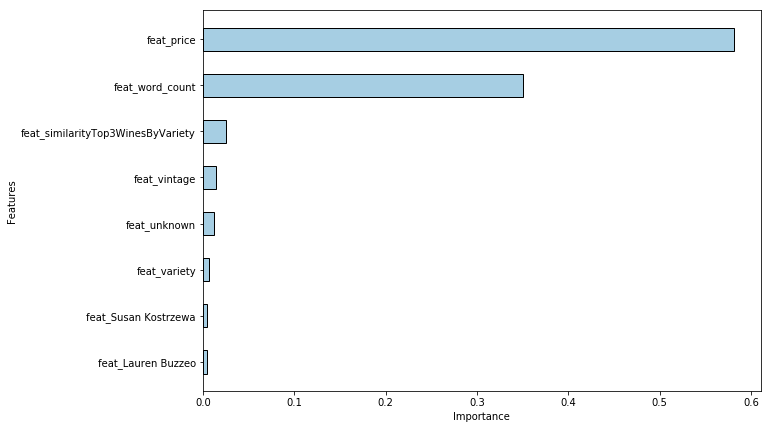

[['feat_Roger Voss', 0.00011335359371848473], ['feat_vintage', 0.0007827593027180753], ['feat_variety', 0.0008098603259131861], ['feat_unknown', 0.0033538307051501903], ['feat_Kerin O’Keefe', 0.024076402305431833], ['feat_similarityTop3WinesByVariety', 0.06347945562463202], ['feat_word_count', 0.2084306612069749], ['feat_price', 0.6989536769354613]]


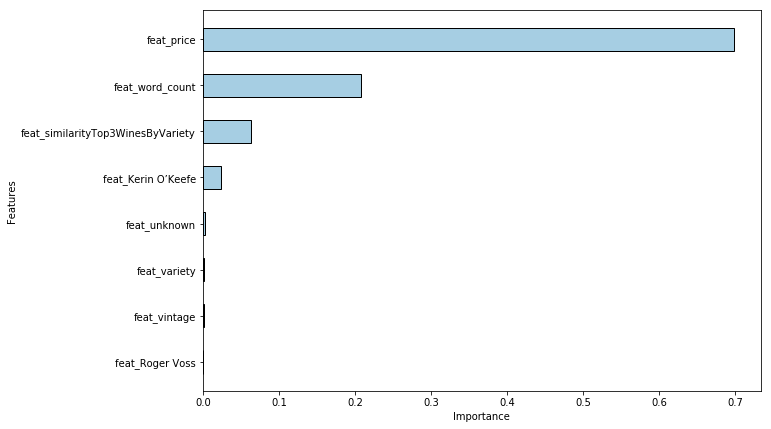

[['feat_Lauren Buzzeo', 0.004654720165973413], ['feat_Susan Kostrzewa', 0.004711868155108124], ['feat_variety', 0.007590882815446912], ['feat_unknown', 0.011424951007069969], ['feat_vintage', 0.013434868267419556], ['feat_similarityTop3WinesByVariety', 0.025385404032768], ['feat_word_count', 0.3515137867164585], ['feat_price', 0.5812835188397554]]


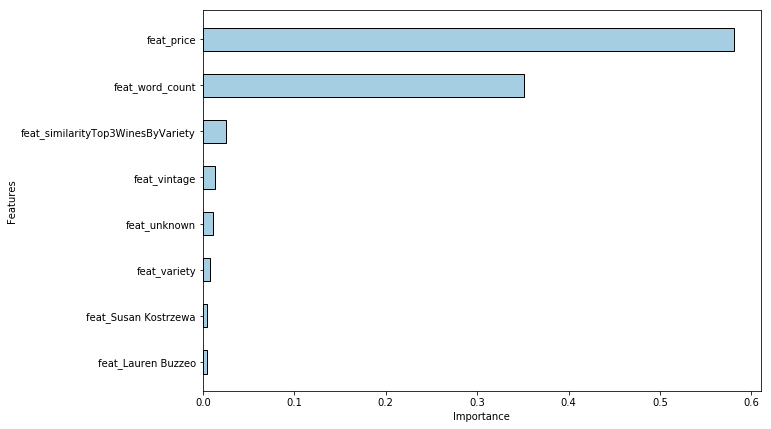

[['feat_Michael Schachner', 0.0007572493230979663], ['feat_variety', 0.007291562505369019], ['feat_vintage', 0.010111507531817434], ['feat_similarityTop3WinesByVariety', 0.03855480686046059], ['feat_word_count', 0.07794201003946323], ['feat_price', 0.8653428637397917]]


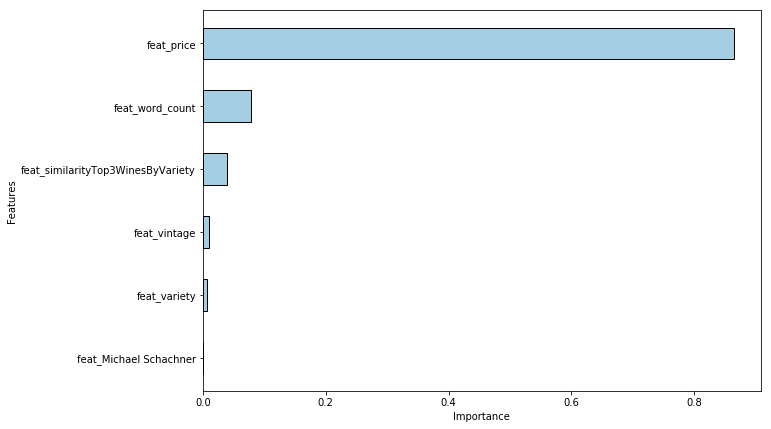

[['feat_Lauren Buzzeo', 0.0040660566627376046], ['feat_Susan Kostrzewa', 0.004711868155108125], ['feat_variety', 0.007590882815446912], ['feat_unknown', 0.012013614510305779], ['feat_vintage', 0.014767659021178875], ['feat_similarityTop3WinesByVariety', 0.024575465901716727], ['feat_word_count', 0.3509909340937505], ['feat_price', 0.5812835188397555]]


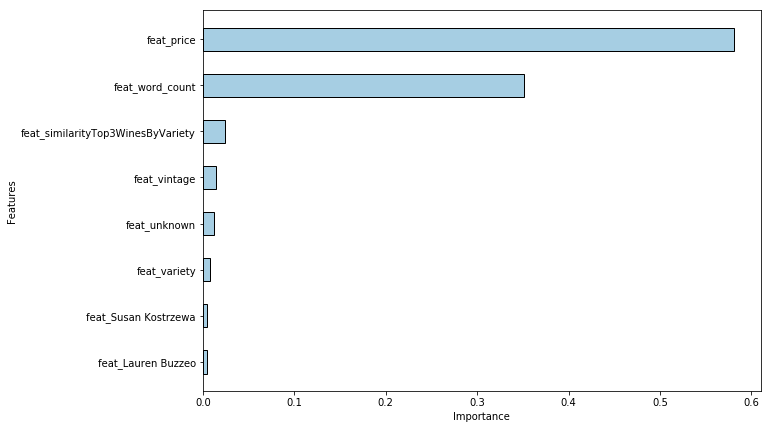

[['feat_Lauren Buzzeo', 0.004654720165973413], ['feat_Susan Kostrzewa', 0.004711868155108124], ['feat_variety', 0.006893745985169531], ['feat_unknown', 0.011947803629778004], ['feat_vintage', 0.014244806398470835], ['feat_similarityTop3WinesByVariety', 0.023679147119931517], ['feat_word_count', 0.3525843897058131], ['feat_price', 0.5812835188397554]]


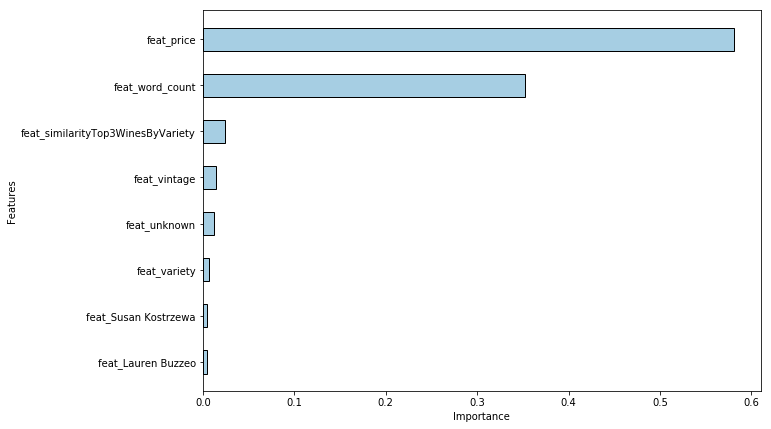

In [134]:
temp = t2
temp = temp.sort_values(["f1"],ascending=False)
temp = temp.tail(10)
print(temp)
for idx,row in temp.iterrows():
    both = []
    for col in temp.columns:
        if row[col] != 0 and col != "combination" and col.startswith("feat"): #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    #plt.title("Target country: "+ temp.iloc[idx]["combination"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()